In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip
import json
import os
from pathlib import Path
import pandas as pd
from collections import defaultdict

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})

def load_and_analyze_features(data_dir):
    """Load and analyze features from all graphs in the dataset."""
    features_dict = defaultdict(list)
    total_nodes = 0
    for file in Path(data_dir).glob('*.json.gz'):
        try:
            with gzip.open(file, 'rt') as f:
                data = json.load(f)
                node_features = data['graph_structure']['node_features']
                total_nodes += len(node_features)
                
                # Aggregate features
                for node in node_features:
                    for key, value in node.items():
                        features_dict[key].append(float(value))         
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue
    return features_dict, total_nodes

def plot_feature_distributions(features_dict, output_dir):
    """Create publication-quality plots of feature distributions."""
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(features_dict)
    # Create plots
    fig_continuous = create_continuous_features_plot(df)
    fig_discrete = create_discrete_features_plot(df)
    fig_binary = create_binary_features_plot(df)
    # Save plots
    fig_continuous.savefig(f'{output_dir}/continuous_features.pdf', bbox_inches='tight', dpi=300)
    fig_discrete.savefig(f'{output_dir}/discrete_features.pdf', bbox_inches='tight', dpi=300)
    fig_binary.savefig(f'{output_dir}/binary_features.pdf', bbox_inches='tight', dpi=300)
    # Generate LaTeX table
    generate_latex_table(df, output_dir)

def create_continuous_features_plot(df):
    """Plot distributions of continuous features."""
    continuous_features = ['mem_ops', 'calls', 'instructions', 'mem_reads', 'mem_writes']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for idx, feature in enumerate(continuous_features):
        sns.histplot(data=df[feature], ax=axes[idx], bins=50, stat='density')
        axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Density')
    if len(continuous_features) < len(axes):
        fig.delaxes(axes[-1])
    fig.suptitle('Distribution of Continuous Features in CFG Nodes')
    plt.tight_layout()
    return fig

def create_discrete_features_plot(df):
    """Plot distributions of discrete features."""
    discrete_features = ['in_degree', 'out_degree', 'stack_ops', 'reg_writes']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for idx, feature in enumerate(discrete_features):
        sns.boxplot(y=df[feature], ax=axes[idx])
        axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution')
        axes[idx].set_ylabel(feature)
    fig.suptitle('Distribution of Discrete Features in CFG Nodes')
    plt.tight_layout()
    return fig

def create_binary_features_plot(df):
    """Plot distributions of binary features."""
    binary_features = ['is_conditional', 'has_jump', 'has_ret']
    fig, ax = plt.subplots(figsize=(10, 6))
    proportions = [df[feat].mean() for feat in binary_features]
    x_pos = np.arange(len(binary_features))
    ax.bar(x_pos, proportions)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([feat.replace('_', ' ').title() for feat in binary_features])
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion of Binary Features in CFG Nodes')
    # Add percentage labels on top of bars
    for i, prop in enumerate(proportions):
        ax.text(i, prop, f'{prop:.1%}', ha='center', va='bottom')
    plt.tight_layout()
    return fig

def generate_latex_table(df, output_dir):
    """Generate LaTeX table with feature statistics."""
    stats = df.agg(['mean', 'std', 'min', 'max', 'median'])
    latex_table = """
    \\begin{table}[h]
    \\centering
    \\caption{Statistics of CFG Node Features}
    \\label{tab:feature-stats}
    \\begin{tabular}{lrrrrr}
    \\toprule
    Feature & Mean & Std & Min & Max & Median \\\\
    \\midrule
    """
    for feature in df.columns:
        latex_table += f"{feature.replace('_', ' ').title()} & "
        latex_table += f"{stats[feature]['mean']:.2f} & "
        latex_table += f"{stats[feature]['std']:.2f} & "
        latex_table += f"{stats[feature]['min']:.0f} & "
        latex_table += f"{stats[feature]['max']:.0f} & "
        latex_table += f"{stats[feature]['median']:.2f} \\\\\n"
    latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}"
    with open(f'{output_dir}/feature_stats.tex', 'w') as f:
        f.write(latex_table)

def main():
    data_dir = '/data/saranyav/gcn_new/cfg_features'  # Update this path
    output_dir = 'feature_analysis'
    os.makedirs(output_dir, exist_ok=True)
    features_dict, total_nodes = load_and_analyze_features(data_dir)
    plot_feature_distributions(features_dict, output_dir)
    print(f"Analyzed {total_nodes} nodes across all graphs")
    print(f"Output saved to {output_dir}/")

if __name__ == "__main__":
    main()

/tmp/ipykernel_3617541/1115658102.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f136dae5a10>>
Traceback (most recent call last):
  File "/home/saranyav/.conda/envs/ctf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


/tmp/ipykernel_4140788/1507244345.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(file)


/tmp/ipykernel_4140788/1507244345.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  types_by_time = df.groupby([pd.Grouper(key='timestamp', freq=f'{bin_hours}H'),


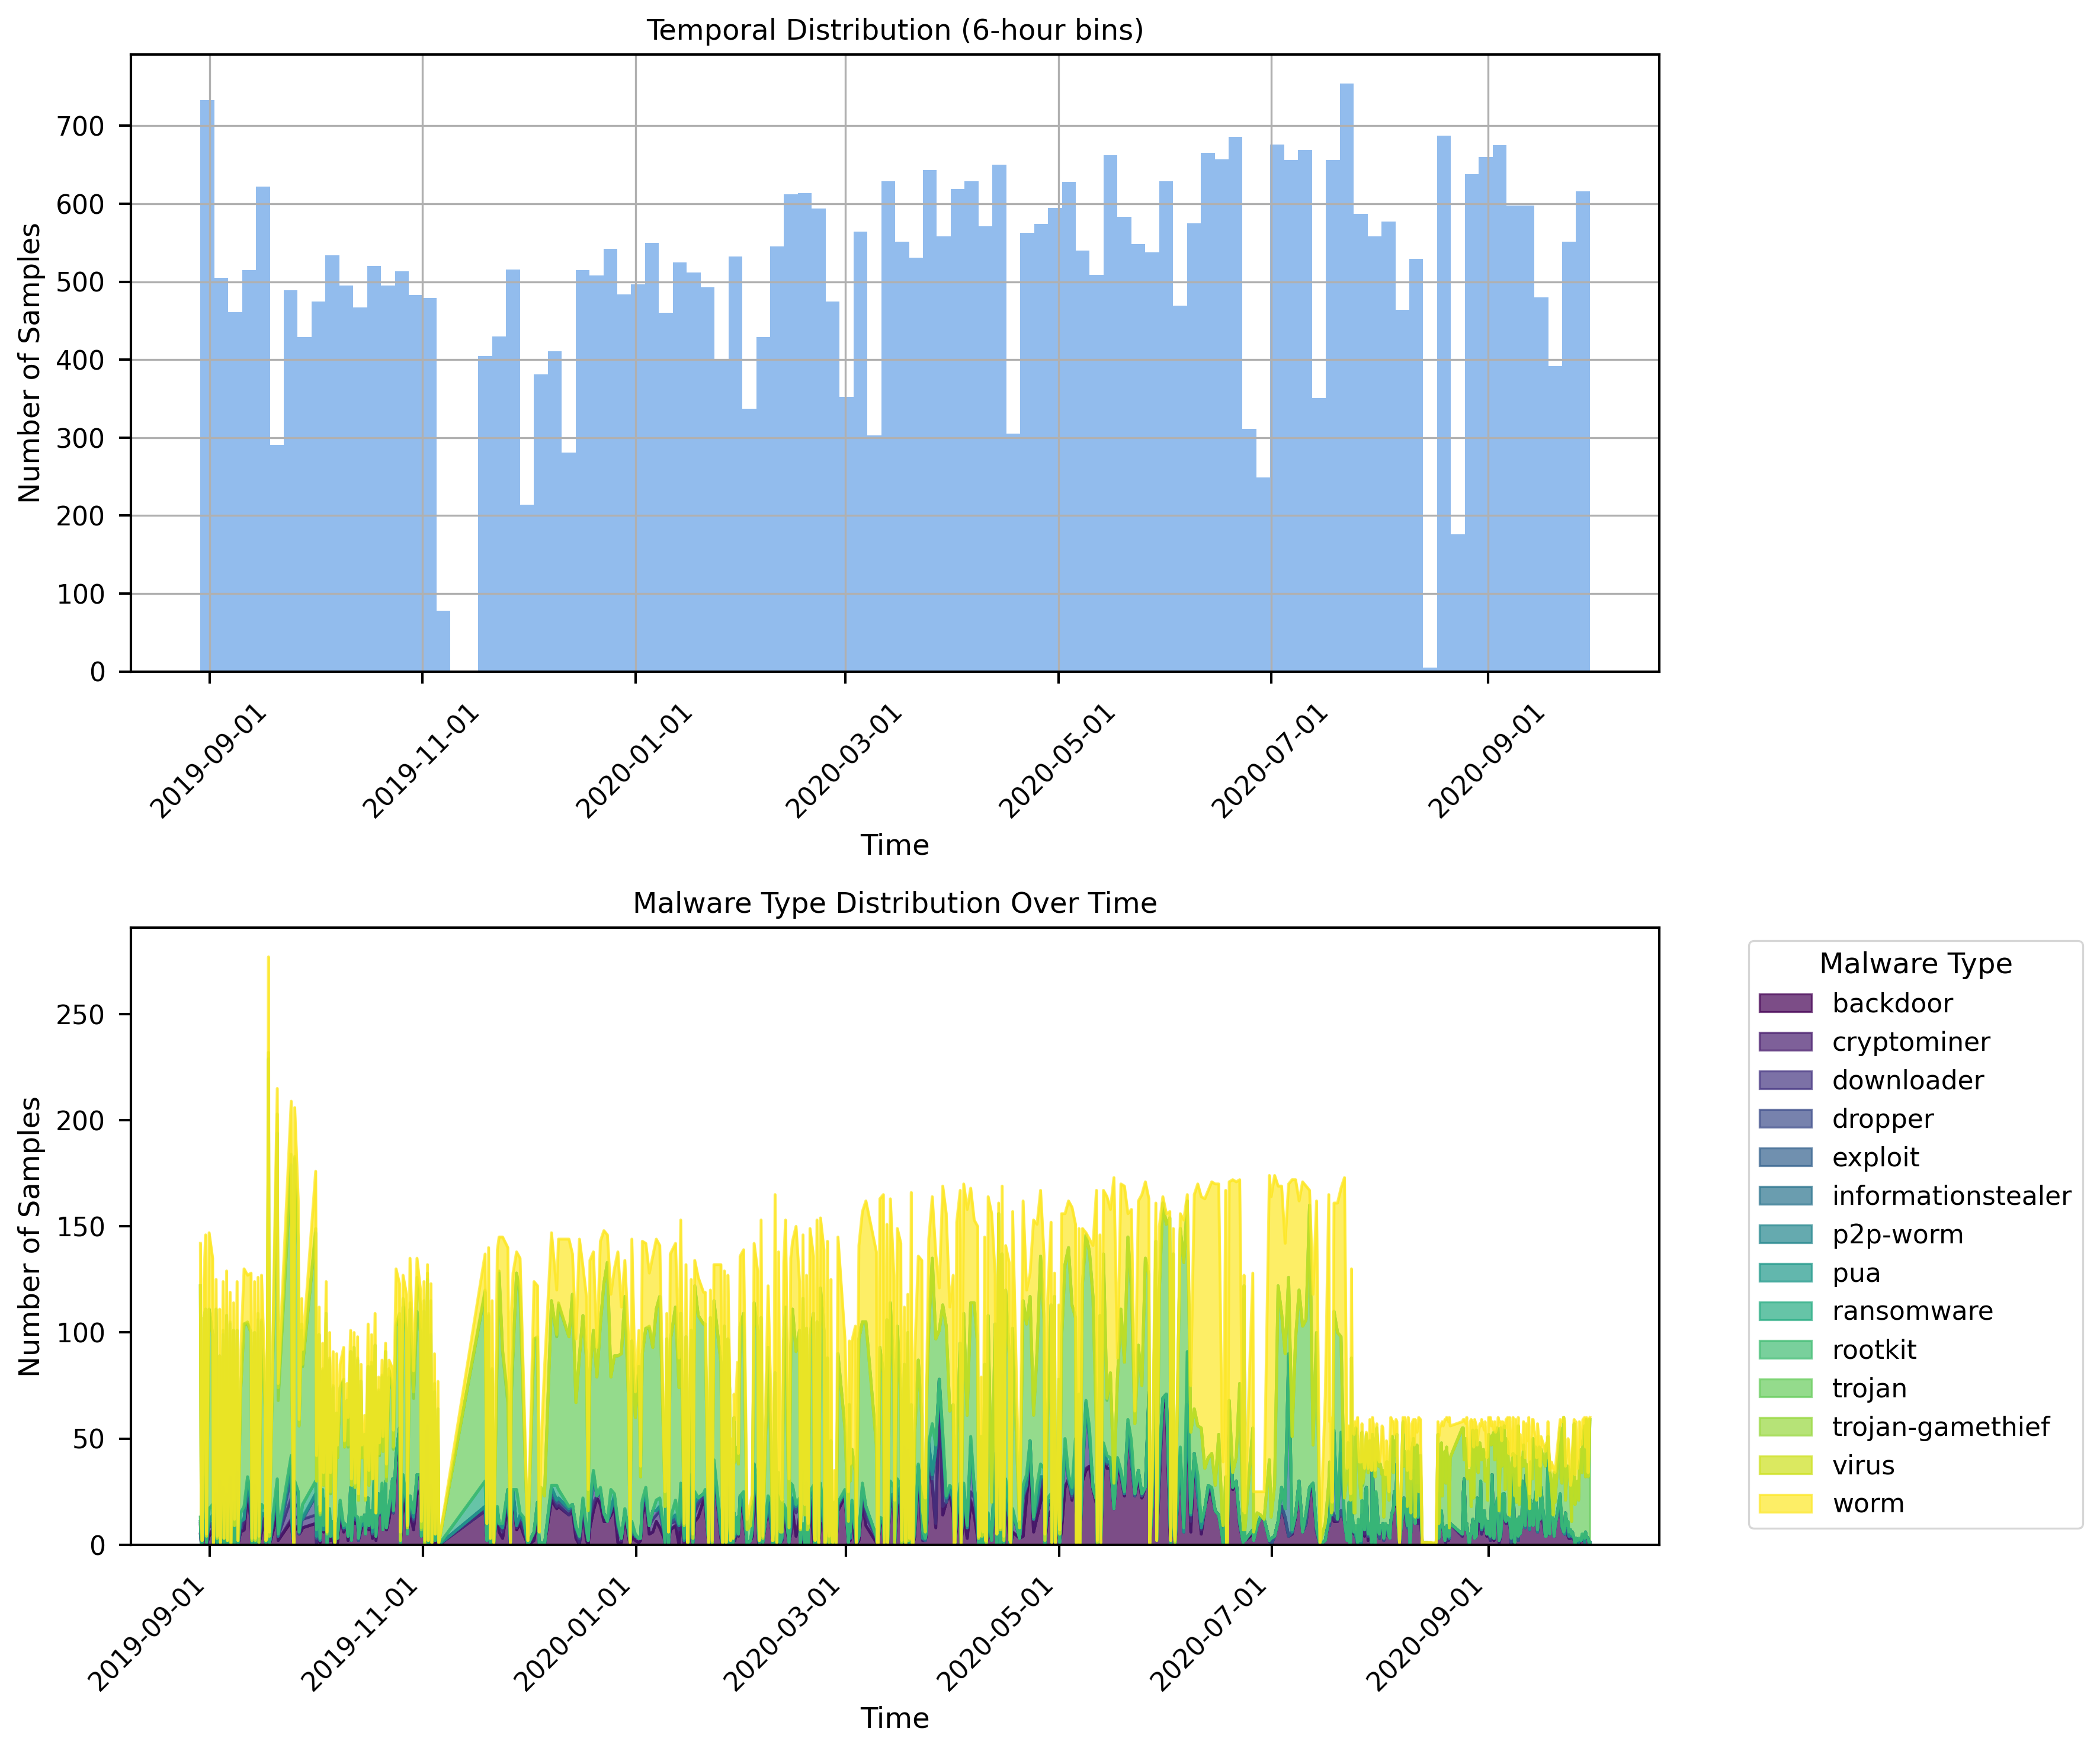

In [28]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_and_analyze_pt_files(data_dir: str):
    pt_files = list(Path(data_dir).rglob("*.pt"))
    data = []
    for file in pt_files:
        try:
            batch = torch.load(file)
            for graph in batch:
                data.append({
                    'timestamp': pd.to_datetime(graph.timestamp),
                    'malware_type': getattr(graph, 'malware_type', 'unknown')
                })
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return pd.DataFrame(data) if data else pd.DataFrame()

def plot_temporal_distribution(df: pd.DataFrame, bin_hours=6):
    if df.empty:
        print("No data to plot")
        return
        
    plt.style.use('seaborn-v0_8-paper')
    sns.set_context("paper", font_scale=1.2)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=300)
    
    # Plot 1: Simple histogram
    df['timestamp'].hist(bins=100, ax=ax1, color='#4a90e2', alpha=0.6)
    ax1.set_title(f'Temporal Distribution ({bin_hours}-hour bins)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Number of Samples')
    
    # Plot 2: Stacked by malware type
    types_by_time = df.groupby([pd.Grouper(key='timestamp', freq=f'{bin_hours}H'), 
                               'malware_type']).size().unstack(fill_value=0)
    types_by_time.plot(kind='area', stacked=True, ax=ax2, colormap='viridis', alpha=0.7)
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    
    ax2.set_title('Malware Type Distribution Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number of Samples')
    ax2.legend(title='Malware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def main():
    data_dir = "/data/saranyav/gcn_new/bodmas_batches"
    df = load_and_analyze_pt_files(data_dir)
    plot_temporal_distribution(df, bin_hours=6)

if __name__ == "__main__":
    main()

/tmp/ipykernel_4140788/3685831213.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(file)


Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0058.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0043.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0051.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0068.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0048.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0053.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0049.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bodmas_batches/test/batch_0071.pt: Cannot compare tz-naive and tz-aware timestamps
Error loading /data/saranyav/gcn_new/bod

/tmp/ipykernel_4140788/3685831213.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  types_by_time = df.groupby([pd.Grouper(key='timestamp', freq=f'{bin_hours}H'),


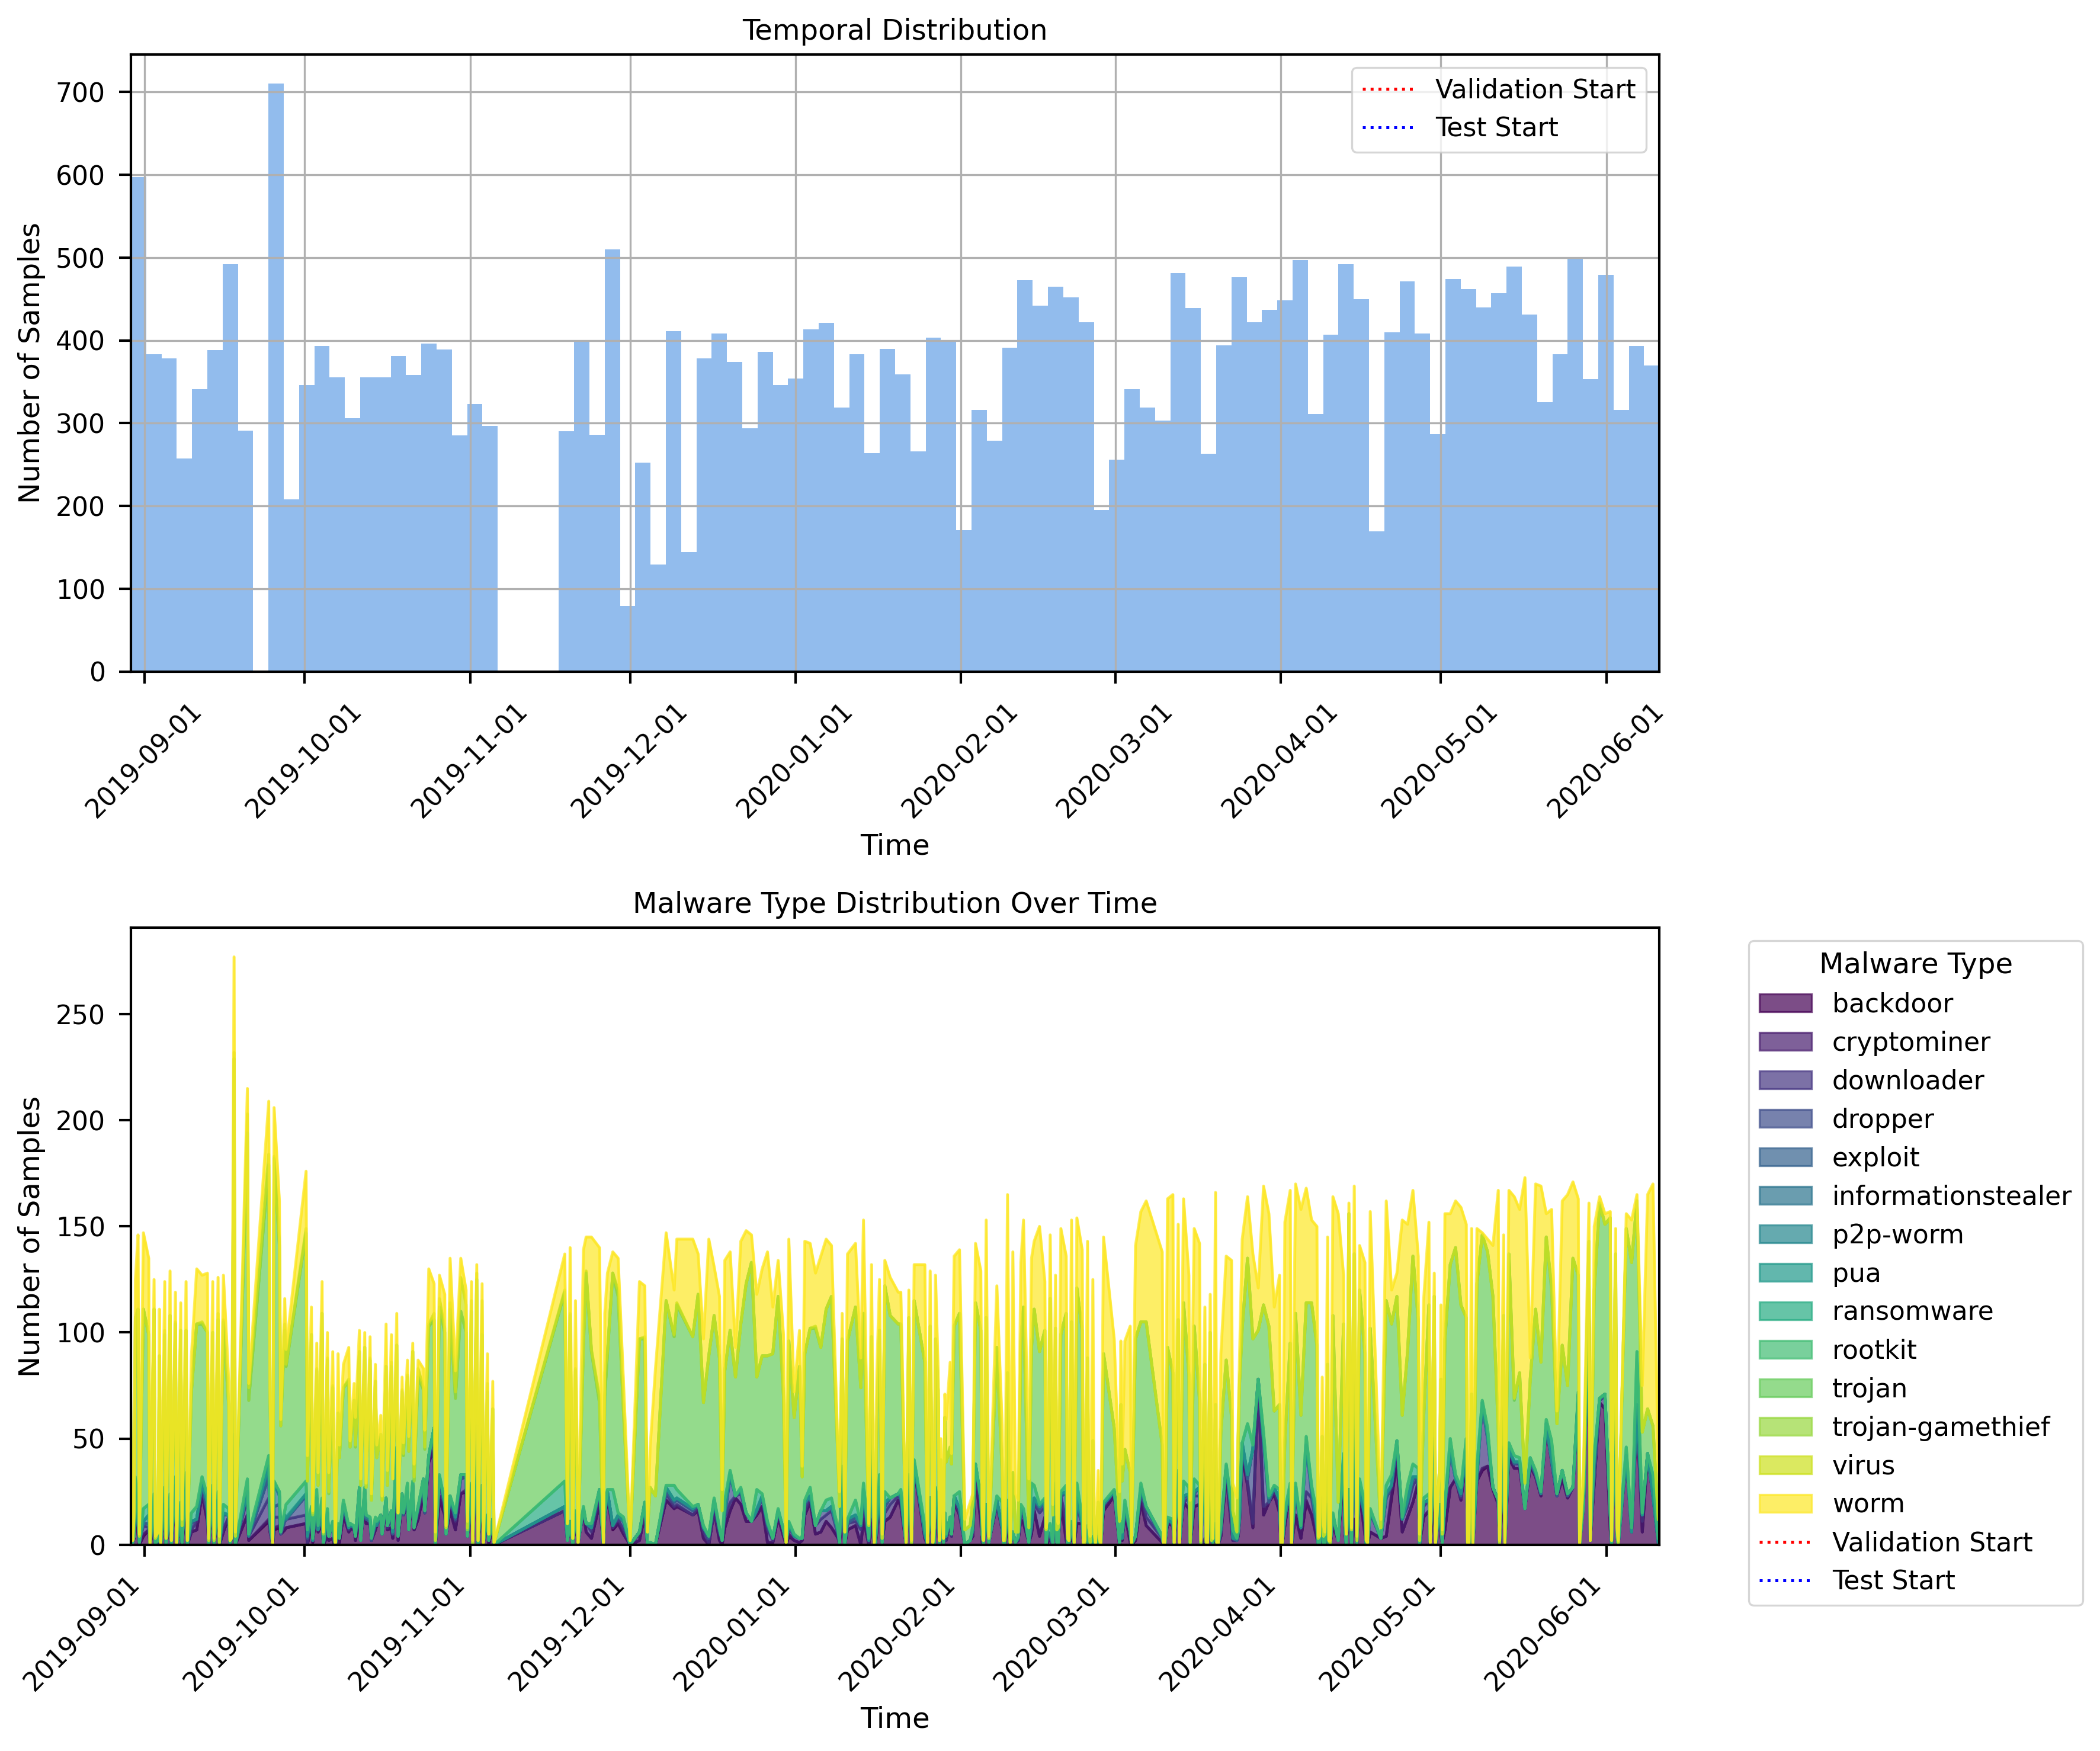

In [29]:
def load_and_analyze_pt_files(data_dir: str):
    pt_files = list(Path(data_dir).rglob("*.pt"))
    data = []
    min_val_time = pd.Timestamp.max
    min_test_time = pd.Timestamp.max
    
    for file in pt_files:
        split = str(file).split('/')[-2]
        try:
            batch = torch.load(file)
            for graph in batch:
                # Convert timestamp assuming it's in nanoseconds
                try:
                    timestamp = pd.to_datetime(graph.timestamp, unit='ns')
                except:
                    timestamp = pd.to_datetime(graph.timestamp)  # fallback
                
                if split == 'val':
                    min_val_time = min(min_val_time, timestamp)
                elif split == 'test':
                    min_test_time = min(min_test_time, timestamp)
                data.append({
                    'timestamp': timestamp,
                    'malware_type': getattr(graph, 'malware_type', 'unknown')
                })
                
                # # Debug print to see raw and converted timestamps
                # print(f"Raw: {graph.timestamp}")
                # print(f"Converted: {timestamp}")
                
        except Exception as e:
            print(f"Error loading {file}: {e}")
            
    return pd.DataFrame(data) if data else pd.DataFrame(), min_val_time, min_test_time

def plot_temporal_distribution(df: pd.DataFrame, val_time, test_time, bin_hours=6):
    if df.empty:
        print("No data to plot")
        return
        
    plt.style.use('seaborn-v0_8-paper')
    sns.set_context("paper", font_scale=1.2)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=300)
    
    # Set x-axis limits based on actual data range
    x_min = df['timestamp'].min()
    x_max = df['timestamp'].max()
    
    # Plot 1
    df['timestamp'].hist(bins=100, ax=ax1, color='#4a90e2', alpha=0.6)
    ax1.set_xlim(x_min, x_max)
    ax1.axvline(x=val_time, color='r', linestyle=':', label='Validation Start')
    ax1.axvline(x=test_time, color='b', linestyle=':', label='Test Start')
    ax1.legend()
    
    # Plot 2
    types_by_time = df.groupby([pd.Grouper(key='timestamp', freq=f'{bin_hours}H'), 
                               'malware_type']).size().unstack(fill_value=0)
    types_by_time.plot(kind='area', stacked=True, ax=ax2, colormap='viridis', alpha=0.7)
    ax2.set_xlim(x_min, x_max)
    ax2.axvline(x=val_time, color='r', linestyle=':', label='Validation Start')
    ax2.axvline(x=test_time, color='b', linestyle=':', label='Test Start')
    
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    
    ax1.set_title('Temporal Distribution')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Number of Samples')
    
    ax2.set_title('Malware Type Distribution Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number of Samples')
    ax2.legend(title='Malware Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def main():
    data_dir = "/data/saranyav/gcn_new/bodmas_batches"
    df, val_time, test_time = load_and_analyze_pt_files(data_dir)
    plot_temporal_distribution(df, val_time, test_time, bin_hours=6)

if __name__ == "__main__":
    main()

In [15]:
import torch
from pathlib import Path

# Load one batch file
pt_files = list(Path("/data/saranyav/gcn_new/bodmas_batches/train").glob("*.pt"))
batch = torch.load(pt_files[0])

# Inspect first graph
g = batch[0]

print("Keys available:", dir(g))
print("\nNumber of nodes:", g.num_nodes)
print("Node features shape:", g.x.shape)
print("Edge index shape:", g.edge_index.shape)
print("Edge attributes shape:", g.edge_attr.shape)

print("\nExample node features (first 3):")
print(g.x[:3])

print("\nMetadata:")
print("SHA:", g.sha)
print("Timestamp:", g.timestamp)
print("Family:", g.family)
print("Malware type:", g.malware_type)

Keys available: ['__annotations__', '__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_edge_attr_cls', '_edge_to_layout', '_edges_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tensor', '_remove_edge_index', '_remove_tensor', '_store', '_tensor_attr_cls', '_to_type', 'apply', 'apply_', 'batch', 'clone', 'coalesce', 'concat', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'coo', 'cpu', 'csc', 'csr', 'cuda', 'debug', 'detach

/tmp/ipykernel_4140788/1131902418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(pt_files[0])


In [20]:
import torch
import gzip
import json

# Read original .gz file
gz_file = '/data/saranyav/gcn_new/cfg_features/33ae3872d37326e6faa7cab6ee00cef543c78c69b007c320e28dee73a0342206.json.gz'
with gzip.open(gz_file, 'rt') as f:
    original = json.load(f)

# Find corresponding .pt file in train/val/test
pt_dirs = ['/data/saranyav/gcn_new/bodmas_batches/train', 
           '/data/saranyav/gcn_new/bodmas_batches/val',
           '/data/saranyav/gcn_new/bodmas_batches/test']

gz_file = '/data/saranyav/gcn_new/cfg_features/33ae3872d37326e6faa7cab6ee00cef543c78c69b007c320e28dee73a0342206.json.gz'

# Calculate totals from the original gz file
with gzip.open(gz_file, 'rt') as f:
    original = json.load(f)
    feature_totals = [sum(node[i] for node in original['graph_structure']['node_features']) 
                     for i in range(14)]
    print("Original totals:", feature_totals)

# Find and calculate totals from corresponding pt file
sha = gz_file.split('/')[-1].split('.')[0]
for dir in pt_dirs:
    for batch_file in Path(dir).glob('*.pt'):
        batch = torch.load(batch_file)
        for graph in batch:
            if getattr(graph, 'sha', '') == sha:
                pt_totals = torch.sum(graph.x, dim=0).tolist()
                print("PT totals:", pt_totals)
                break

Original totals: [98.0, 163.0, 705.0, 81.0, 468.0, 0.0, 163.0, 14.0, 21.0, 1597.0, 1597.0, 20.0, 0.0, 163.0]
PT totals: [98.0, 163.0, 705.0, 81.0, 468.0, 0.0, 163.0, 14.0, 21.0, 1597.0, 1597.0, 20.0, 0.0, 163.0]


/tmp/ipykernel_4140788/285843159.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(batch_file)


/tmp/ipykernel_4140788/810332689.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(batch_file)


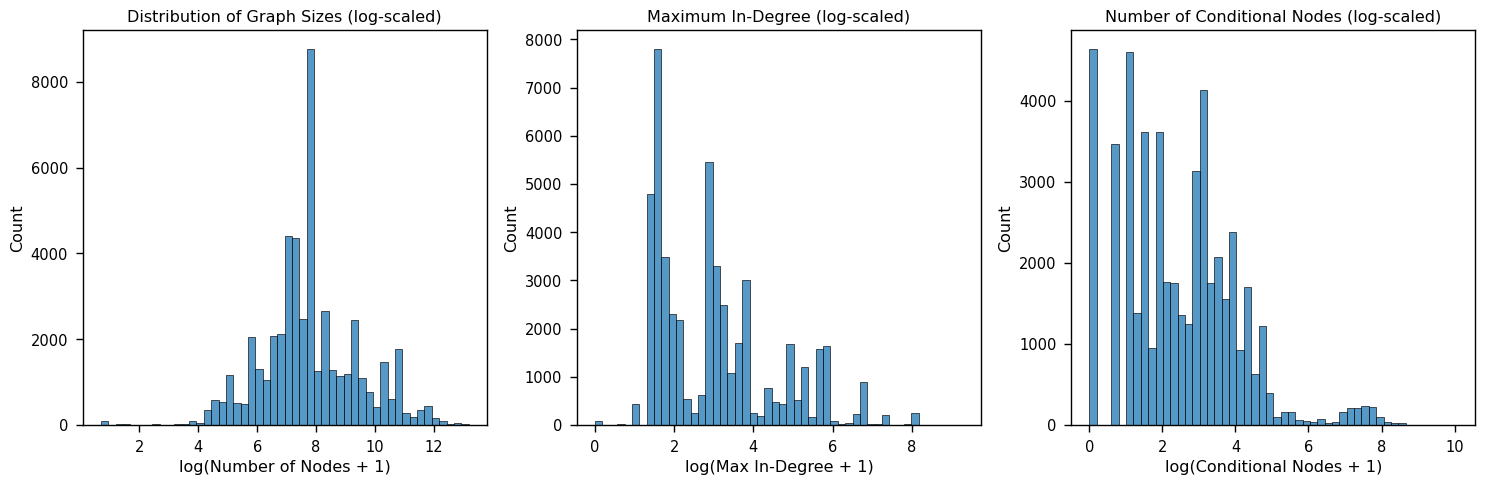


Log-transformed Statistics:
          num_nodes  max_in_degree  num_conditionals
count  50286.000000   50286.000000      50286.000000
mean       7.798190       3.033951          2.464579
std        1.640028       1.516616          1.578725
min        0.693147       0.000000          0.000000
25%        6.933423       1.609438          1.098612
50%        7.761745       2.890372          2.397895
75%        8.665786       3.806662          3.465736
max       13.178816       9.292934         10.067900

Summary Statistics:
           num_nodes      num_edges    avg_degree  max_in_degree  \
count   50286.000000   50286.000000  50286.000000   50286.000000   
mean    10154.955773   12716.337907      1.241369      90.742374   
std     26990.934257   32018.843946      0.198080     290.698637   
min         1.000000       0.000000      0.000000       0.000000   
25%      1025.000000    1205.000000      1.063742       4.000000   
50%      2348.000000    2579.000000      1.267997      17.000000 

In [30]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_graph_stats(data_dir):
   stats = []
   for batch_file in Path(data_dir).rglob("*.pt"):
       batch = torch.load(batch_file)
       for graph in batch:
           stats.append({
               'num_nodes': graph.num_nodes,
               'num_edges': graph.edge_index.size(1),
               'avg_degree': graph.edge_index.size(1) / graph.num_nodes,
               'max_in_degree': torch.max(graph.x[:, 9]).item(),
               'max_out_degree': torch.max(graph.x[:, 10]).item(),
               'num_conditionals': torch.sum(graph.x[:, 11]).item(),
               'num_returns': torch.sum(graph.x[:, 13]).item()
           })
   return pd.DataFrame(stats)

def plot_distributions(df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Log-scale for num_nodes
    sns.histplot(data=np.log1p(df['num_nodes']), bins=50, ax=axes[0])
    axes[0].set_title('Distribution of Graph Sizes (log-scaled)')
    axes[0].set_xlabel('log(Number of Nodes + 1)')
    
    # Log-scale for max_in_degree
    sns.histplot(data=np.log1p(df['max_in_degree']), bins=50, ax=axes[1])
    axes[1].set_title('Maximum In-Degree (log-scaled)')
    axes[1].set_xlabel('log(Max In-Degree + 1)')
    
    # Log-scale for num_conditionals
    sns.histplot(data=np.log1p(df['num_conditionals']), bins=50, ax=axes[2])
    axes[2].set_title('Number of Conditional Nodes (log-scaled)')
    axes[2].set_xlabel('log(Conditional Nodes + 1)')
    
    plt.tight_layout()
    plt.show()
    
    print("\nLog-transformed Statistics:")
    log_df = df.copy()
    for col in ['num_nodes', 'max_in_degree', 'num_conditionals']:
        log_df[col] = np.log1p(log_df[col])
    print(log_df[['num_nodes', 'max_in_degree', 'num_conditionals']].describe())
    

data_dir = "/data/saranyav/gcn_new/bodmas_batches"
df = load_graph_stats(data_dir)
plot_distributions(df)

print("\nSummary Statistics:")
print(df.describe())

/tmp/ipykernel_4140788/1868276701.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(batch_file)


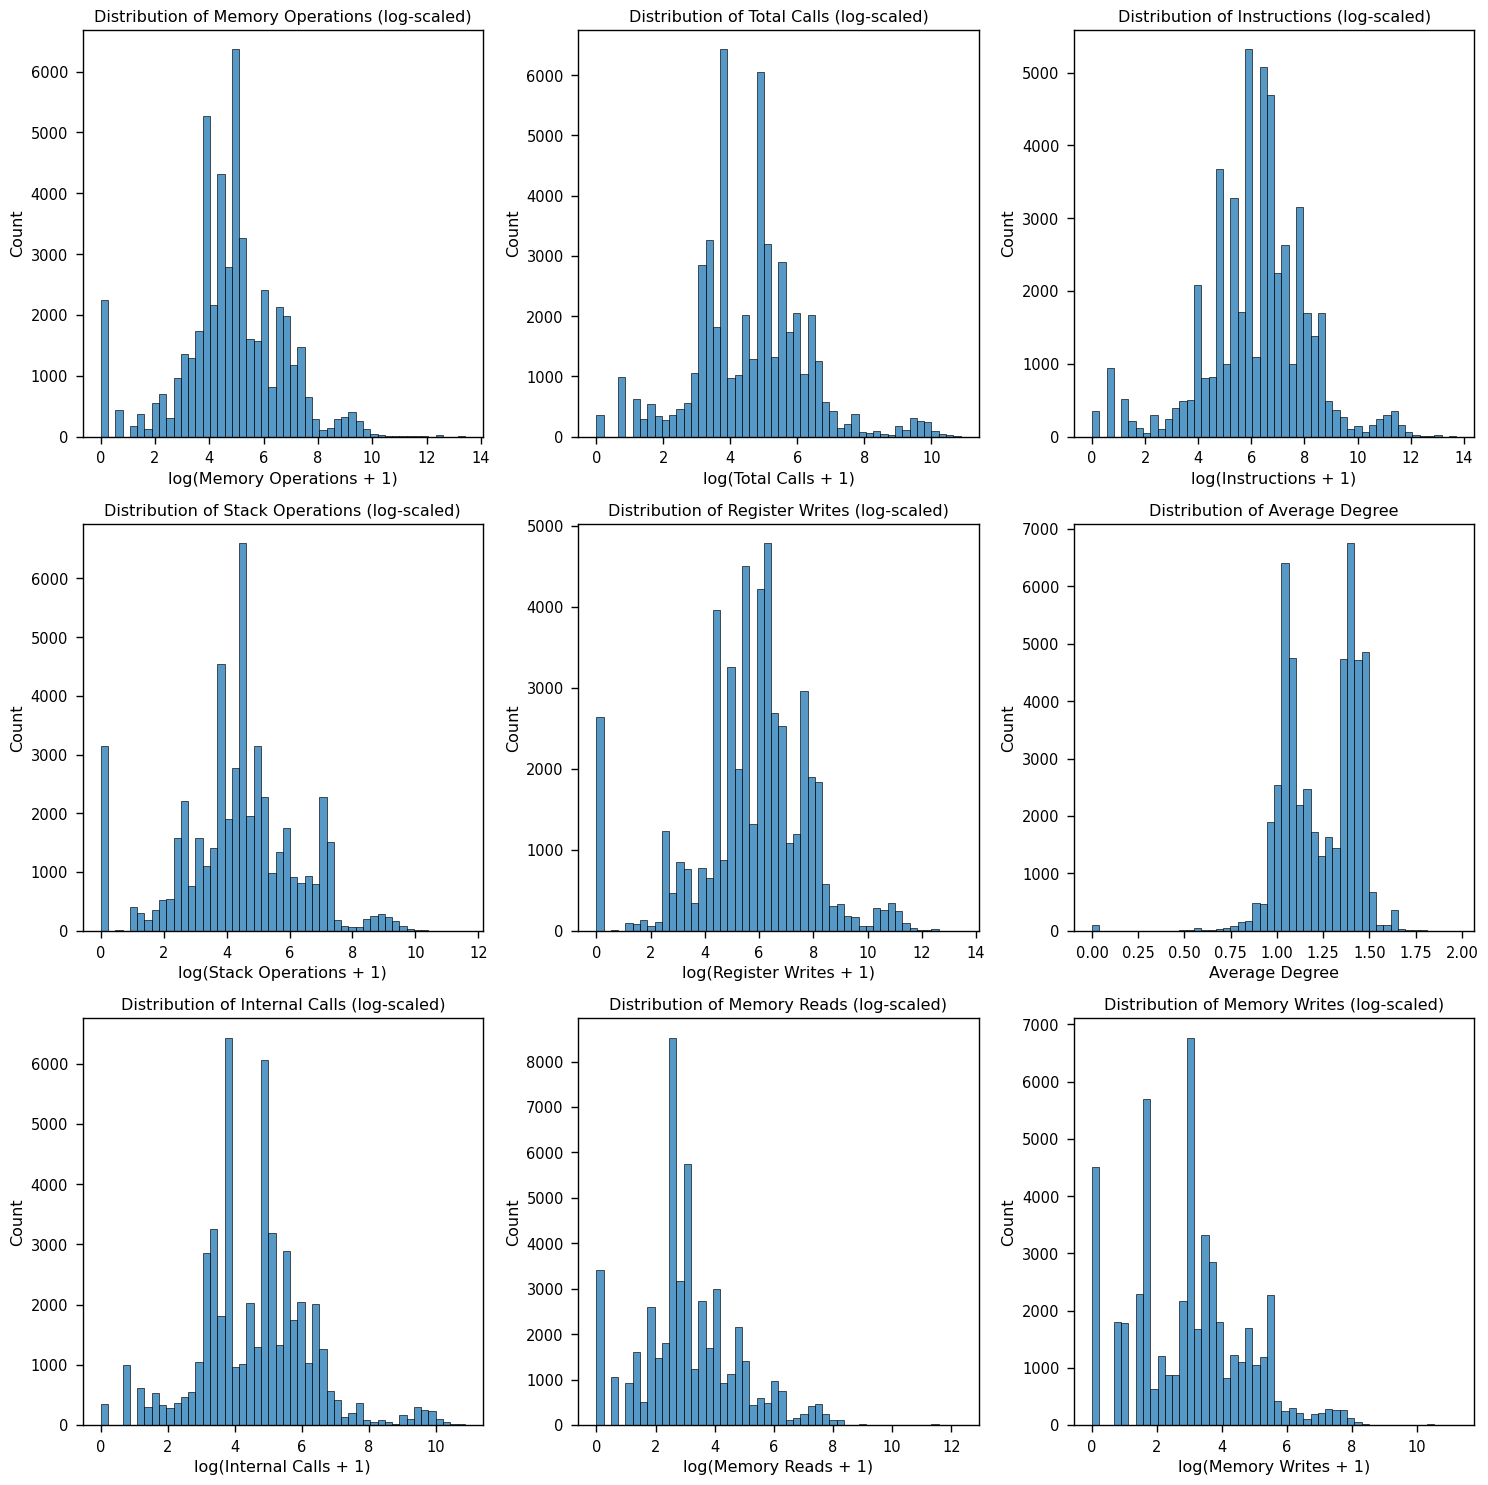


Feature Statistics:
             mem_ops         calls   instructions      stack_ops  \
count   50286.000000  50286.000000   50286.000000   50286.000000   
mean      844.722885    623.150897    3594.909955     446.426321   
std      8676.551128   2788.188503   17732.547334    1552.665661   
min         0.000000      0.000000       0.000000       0.000000   
25%        51.000000     35.000000     185.000000      30.000000   
50%       125.000000    108.000000     582.000000      84.000000   
75%       369.000000    273.000000    1431.000000     220.000000   
max    668310.000000  52772.000000  900852.000000  106173.000000   

          reg_writes    avg_degree  internal_calls      mem_reads  \
count   50286.000000  50286.000000    50286.000000   50286.000000   
mean     2482.901643      1.241369      623.150897     189.554389   
std     12588.213786      0.198080     2788.188503    2837.198696   
min         0.000000      0.000000        0.000000       0.000000   
25%       110.000000 

In [27]:
def load_graph_feature_stats(data_dir):
    stats = []
    for batch_file in Path(data_dir).rglob("*.pt"):
        batch = torch.load(batch_file)
        for graph in batch:
            stats.append({
                'mem_ops': torch.sum(graph.x[:, 0]).item(),
                'calls': torch.sum(graph.x[:, 1]).item(),
                'instructions': torch.sum(graph.x[:, 2]).item(),
                'stack_ops': torch.sum(graph.x[:, 3]).item(),
                'reg_writes': torch.sum(graph.x[:, 4]).item(),
                'avg_degree': graph.edge_index.size(1) / graph.num_nodes,
                'internal_calls': torch.sum(graph.x[:, 6]).item(),
                'mem_reads': torch.sum(graph.x[:, 7]).item(),
                'mem_writes': torch.sum(graph.x[:, 8]).item(),
            })
    return pd.DataFrame(stats)

def plot_instruction_distributions(df):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    titles = {
        'mem_ops': 'Memory Operations',
        'calls': 'Total Calls',
        'instructions': 'Instructions',
        'stack_ops': 'Stack Operations',
        'reg_writes': 'Register Writes',
        'avg_degree': 'Average Degree',
        'internal_calls': 'Internal Calls',
        'mem_reads': 'Memory Reads',
        'mem_writes': 'Memory Writes'
    }
    
    for idx, col in enumerate(df.columns):
        if col != 'avg_degree':
            data = np.log1p(df[col])
            label = f'log({titles[col]} + 1)'
            title = f'Distribution of {titles[col]} (log-scaled)'
        else:
            data = df[col]
            label = titles[col]
            title = f'Distribution of {titles[col]}'
            
        sns.histplot(data=data, bins=50, ax=axes[idx])
        axes[idx].set_title(title)
        axes[idx].set_xlabel(label)
    
    plt.tight_layout()
    plt.show()

data_dir = "/data/saranyav/gcn_new/bodmas_batches"
df = load_graph_feature_stats(data_dir)
plot_instruction_distributions(df)
print("\nFeature Statistics:")
print(df.describe())

In [ ]:
import gzip
import json

def inspect_saved_features(file_path):
    # Read and parse the gzipped JSON file
    with gzip.open(file_path, 'rt') as f:
        data = json.load(f)
    
    # Print high-level structure
    print("File structure:")
    for key in data:
        print(f"- {key}")
    
    print("\nGraph structure details:")
    for key in data['graph_structure']:
        print(f"- {key}")
    
    # Print basic graph stats
    print(f"\nNumber of nodes: {data['graph_structure']['num_nodes']}")
    print(f"Number of edges: {len(data['graph_structure']['edge_index'])}")
    
    # Look at node features
    node_features = data['graph_structure']['node_features']
    if node_features:
        print("\nFeature dimensions:")
        print(f"Number of nodes: {len(node_features)}")
        print(f"Features per node: {len(node_features[0])}")
        
        # Find a node with interesting features (non-zero)
        feature_sums = [sum(features) for features in node_features]
        interesting_node_idx = feature_sums.index(max(feature_sums))
        
        # Feature keys in order
        feature_keys = [
            'mem_ops', 'calls', 'instructions', 'stack_ops', 'reg_writes',
            'external_calls', 'internal_calls', 'mem_reads', 'mem_writes',
            'in_degree', 'out_degree', 'is_conditional', 'has_jump', 'has_ret'
        ]
        
        # Show features for most interesting node
        print(f"\nMost active node (index {interesting_node_idx}) feature values:")
        features = node_features[interesting_node_idx]
        for key, value in zip(feature_keys, features):
            if value > 0:  # Only show non-zero features
                print(f"{key}: {value}")
        
        # Calculate and show totals across all nodes
        print("\nTotal counts across all nodes:")
        totals = {key: sum(node[i] for node in node_features) 
                 for i, key in enumerate(feature_keys)}
        for key, value in totals.items():
            if value > 0:  # Only show non-zero totals
                print(f"{key}: {value}")

# Test the file
file_path = '/data/saranyav/gcn_new/cfg_features/3cdcb810166c50fb360d9e73e51708192b4f295dc5c58cb0d27847c7de6f253a.json.gz'
inspect_saved_features(file_path)

File structure:
- file
- graph_structure
- timestamp

Graph structure details:
- num_nodes
- node_features
- edge_index
- edge_features
- node_mapping

Number of nodes: 12358
Number of edges: 17918

Feature dimensions:
Number of nodes: 12358
Features per node: 14

Most active node (index 110) feature values:
in_degree: 329.0
out_degree: 2.0

Total counts across all nodes:
mem_ops: 1058.0
calls: 370.0
instructions: 2678.0
stack_ops: 1102.0
reg_writes: 2180.0
internal_calls: 370.0
mem_reads: 60.0
mem_writes: 259.0
in_degree: 17918.0
out_degree: 17918.0
is_conditional: 46.0
has_ret: 370.0


In [16]:
import json
import gzip
from pathlib import Path

# Load original gz file with same SHA
sha = "33ae3872d37326e6faa7cab6ee00cef543c78c69b007c320e28dee73a0342206"
gz_file = f"/data/saranyav/gcn_new/cfg_features/{sha}.json.gz"

with gzip.open(gz_file, 'rt') as f:
    data = json.load(f)
    
print("Original features from first few nodes:")
print(data['graph_structure']['node_features'][:3])

Original features from first few nodes:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0]]


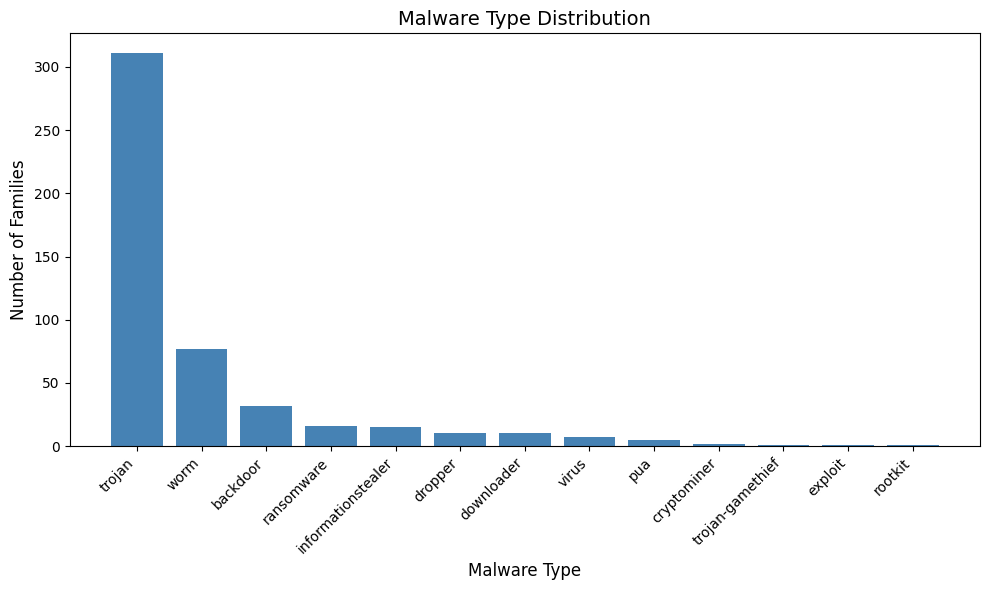

In [11]:
import matplotlib.pyplot as plt

# Data
categories = [
    "trojan", "worm", "backdoor", "ransomware", "informationstealer", 
    "dropper", "downloader", "virus", "pua", "cryptominer", 
    "trojan-gamethief", "exploit", "rootkit"
]
family_counts = [311, 77, 32, 16, 15, 10, 10, 7, 5, 2, 1, 1, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, family_counts, color="steelblue")
plt.xlabel("Malware Type", fontsize=12)
plt.ylabel("Number of Families", fontsize=12)
plt.title("Malware Type Distribution", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save or show the plot
plt.savefig("malware_type_distribution.png", dpi=300)  # Save if needed
plt.show()

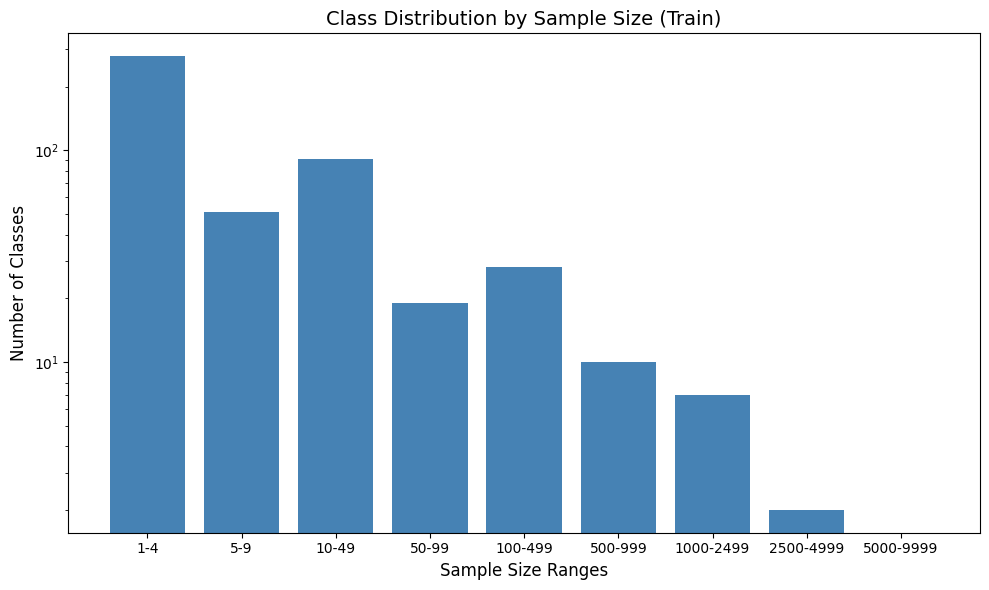

In [18]:
import matplotlib.pyplot as plt
import numpy as np
class_distribution =  {30: 684, 362: 29, 193: 86, 215: 30, 199: 3, 162: 267, 288: 15, 386: 45, 462: 3210, 263: 1559, 434: 3413, 111: 9, 76: 325, 313: 21, 431: 787, 70: 37, 226: 14, 267: 75, 285: 153, 439: 79, 387: 2306, 379: 82, 376: 928, 118: 79, 300: 655, 120: 36, 274: 245, 116: 1297, 436: 617, 337: 190, 170: 941, 182: 724, 154: 47, 465: 4, 122: 123, 336: 45, 206: 37, 335: 1, 243: 6, 460: 1438, 172: 600, 253: 14, 456: 131, 408: 31, 58: 90, 372: 109, 410: 298, 99: 3, 403: 126, 295: 118, 424: 1, 418: 52, 402: 209, 13: 36, 458: 75, 368: 2151, 309: 472, 228: 17, 129: 66, 378: 24, 293: 25, 28: 11, 390: 84, 314: 107, 97: 53, 312: 36, 163: 27, 273: 1025, 150: 49, 47: 1384, 126: 54, 247: 369, 158: 2, 482: 157, 190: 44, 437: 22, 271: 6, 393: 261, 268: 46, 72: 4, 234: 6, 33: 581, 385: 59, 432: 5, 447: 237, 478: 4, 153: 133, 61: 15, 86: 237, 297: 7, 55: 404, 329: 28, 325: 6, 302: 1, 357: 1, 5: 144, 370: 3, 106: 21, 133: 16, 2: 22, 41: 47, 332: 266, 185: 31, 197: 1, 363: 42, 281: 12, 53: 2, 430: 5, 352: 1, 480: 17, 167: 18, 225: 41, 413: 59, 78: 3, 227: 8, 110: 434, 113: 9, 207: 1, 454: 6, 412: 83, 95: 131, 16: 32, 143: 3, 455: 2, 43: 136, 175: 37, 279: 12, 440: 45, 353: 11, 80: 24, 409: 16, 316: 3, 217: 1, 156: 3, 476: 3, 367: 2, 483: 20, 130: 14, 202: 27, 348: 5, 20: 2, 449: 16, 82: 2, 138: 4, 31: 6, 210: 136, 426: 1, 146: 2, 442: 11, 277: 12, 147: 8, 65: 1, 200: 1, 171: 57, 68: 7, 81: 2, 141: 48, 327: 10, 32: 1, 49: 3, 59: 49, 469: 6, 471: 2, 450: 3, 140: 10, 164: 2, 87: 4, 52: 2, 244: 1, 209: 1, 457: 1, 109: 1, 358: 1, 270: 15, 8: 1, 48: 19, 395: 1, 421: 21, 98: 1, 19: 10, 388: 43, 145: 1, 346: 1, 229: 1, 26: 1, 45: 1, 224: 3, 93: 1, 220: 1, 105: 55, 218: 6, 173: 1, 257: 19, 74: 4, 350: 3, 284: 5, 328: 2, 303: 2, 132: 10, 318: 14, 371: 4, 308: 15, 152: 13, 451: 32, 414: 23, 296: 18, 51: 2, 42: 1, 265: 8, 473: 7, 391: 1, 470: 1, 354: 9, 232: 6, 453: 1, 22: 1, 124: 3, 366: 1, 18: 2, 420: 13, 375: 21, 186: 1, 64: 9, 204: 2, 40: 6, 9: 2, 384: 1, 435: 8, 468: 2, 347: 1, 6: 4, 165: 2, 251: 14, 159: 3, 151: 6, 236: 1, 320: 4, 117: 6, 27: 88, 115: 1, 134: 1, 176: 1, 338: 7, 183: 5, 235: 2, 135: 45, 373: 4, 139: 2, 3: 2, 294: 3, 4: 8, 341: 2, 261: 2, 252: 3, 23: 4, 71: 2, 423: 4, 238: 11, 422: 3, 248: 1, 62: 1, 326: 6, 29: 3, 192: 1, 311: 5, 276: 1, 399: 2, 291: 3, 398: 60, 397: 8, 427: 5, 223: 9, 174: 1, 149: 2, 198: 1, 307: 1, 250: 1, 168: 1, 231: 11, 221: 2, 77: 1, 383: 34, 404: 2, 108: 10, 425: 2, 85: 1, 79: 2, 452: 5, 203: 3, 102: 2, 474: 3, 359: 1, 189: 1, 180: 3, 258: 1, 101: 1, 282: 1, 433: 28, 188: 1, 466: 2, 36: 4, 255: 1, 125: 4, 292: 13, 44: 1, 178: 1, 230: 5, 60: 2, 137: 2, 123: 1, 319: 1, 160: 4, 467: 2, 10: 1, 148: 122, 344: 9, 56: 2, 39: 1, 142: 1, 264: 11, 14: 15, 343: 2, 443: 2, 339: 588, 310: 13, 184: 5, 407: 1, 88: 1, 205: 1, 0: 1, 240: 10, 211: 1, 364: 1, 260: 2, 272: 5, 177: 3, 369: 3, 37: 1, 254: 1, 208: 38, 21: 2, 401: 1, 57: 10, 441: 4, 166: 7, 461: 3, 438: 1, 322: 5, 301: 3, 69: 1, 241: 1, 96: 3, 484: 5, 266: 16, 479: 3, 323: 1, 92: 2, 103: 2, 290: 2, 446: 1, 459: 1, 444: 2, 83: 1, 286: 4, 38: 1, 112: 4, 417: 1, 333: 12, 381: 7, 416: 1, 84: 1, 356: 2, 107: 4, 278: 1, 25: 2, 239: 3, 365: 7, 144: 1, 89: 1, 249: 6, 196: 1, 256: 1, 445: 1, 246: 2, 405: 1, 289: 13, 345: 1, 127: 2, 50: 8, 212: 2, 242: 21, 54: 1, 298: 2, 396: 2, 411: 1, 34: 1, 275: 1, 324: 1, 214: 1, 305: 1, 11: 1, 330: 1, 355: 1, 7: 25, 128: 1, 374: 3, 119: 3, 91: 1, 406: 2, 46: 1, 195: 1, 222: 2, 340: 1, 131: 2, 114: 1, 392: 1, 73: 3, 415: 1, 216: 5, 486: 1, 448: 1, 464: 1, 90: 1, 331: 1, 321: 3, 155: 1, 24: 10, 66: 2, 475: 3, 121: 1, 472: 1, 1: 1, 463: 1, 100: 1, 306: 1, 136: 1, 361: 4, 213: 1, 481: 1, 262: 1, 283: 1, 342: 1, 389: 1, 157: 1, 12: 5, 382: 1, 394: 2, 349: 1, 35: 1, 485: 1, 269: 1, 428: 1, 194: 1, 63: 1, 299: 1, 187: 2, 67: 1, 377: 11, 169: 4, 237: 1, 334: 8, 477: 6, 75: 1, 179: 1, 304: 1, 15: 2, 287: 1, 360: 1, 317: 2, 245: 16, 233: 17, 94: 1, 104: 2, 419: 1, 429: 1, 400: 1, 351: 1, 280: 1, 201: 1, 380: 1, 181: 1, 219: 1, 17: 2, 191: 1, 315: 1, 161: 1, 259: 1}

# Group the sample sizes into bins
sample_sizes = list(class_distribution.values())
bins = [1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]  # Define bins
binned_counts = np.histogram(sample_sizes, bins=bins)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)],
    binned_counts[0],
    color="steelblue",
)
plt.xlabel("Sample Size Ranges", fontsize=12)
plt.yscale('log')  # Log scale for better visualization
plt.ylabel("Number of Classes", fontsize=12)
plt.title("Class Distribution by Sample Size (Train)", fontsize=14)
plt.tight_layout()

# Save or show the plot
plt.savefig("class_distribution_histogram.png", dpi=300)  # Save if needed
plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import json
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def create_similarity_matrix_plot(similarity_matrix, output_dir):
    """Create an enhanced similarity matrix visualization."""
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap from white to dark blue
    colors = ['#ffffff', '#edf3f9', '#d0e1f2', '#a1c4e6', '#6ea6d9', '#4889c2', '#2e6aa6', '#1e4b79', '#0e2f4c']
    n_bins = 100
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    # Plot heatmap with custom styling
    sns.heatmap(similarity_matrix, 
                cmap=custom_cmap,
                square=True,
                xticklabels=False, 
                yticklabels=False)
    
    plt.title('Malware Family Similarity Matrix', pad=20, fontsize=14)
    plt.xlabel('Family Index', fontsize=12)
    plt.ylabel('Family Index', fontsize=12)
    
    # Add colorbar label
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label('Similarity Score', fontsize=12, labelpad=10)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'similarity_matrix_enhanced.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_group_size_analysis(groups_data, output_dir):
    """Create visualization of behavioral group sizes and composition."""
    fig = plt.figure(figsize=(15, 6))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[2, 1])
    
    # Left plot: Group sizes
    ax1 = fig.add_subplot(gs[0])
    group_sizes = [len(families) for families in groups_data.values()]
    
    # Create bar plot with gradient colors
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(group_sizes)))
    bars = ax1.bar(range(len(group_sizes)), sorted(group_sizes, reverse=True), color=colors)
    
    ax1.set_xlabel('Behavioral Group ID', fontsize=12)
    ax1.set_ylabel('Number of Families', fontsize=12)
    ax1.set_title('Distribution of Behavioral Group Sizes', pad=20, fontsize=14)
    
    # Right plot: Group size distribution
    ax2 = fig.add_subplot(gs[1])
    sns.histplot(data=group_sizes, bins=min(20, len(set(group_sizes))), ax=ax2, color='#2e6aa6')
    ax2.set_xlabel('Group Size', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Group Size Distribution', pad=20, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'group_size_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_behavioral_pattern_heatmap(family_distributions, output_dir):
    """Create heatmap of behavioral patterns across groups."""
    # Extract behavior patterns for each family
    patterns_data = []
    for family, dist in family_distributions.items():
        if 'behavior_patterns' in dist:
            patterns = dist['behavior_patterns']
            patterns_data.append([patterns.get(p, 0) for p in ['ext_call', 'mem_rw', 'cond_jump', 'ext_write']])
    
    patterns_array = np.array(patterns_data)
    
    plt.figure(figsize=(10, 6))
    
    # Create heatmap with custom styling
    sns.heatmap(patterns_array.T, 
                cmap='YlOrRd',
                xticklabels=False,
                yticklabels=['External Calls', 'Memory R/W', 'Conditional Jumps', 'External Writes'])
    
    plt.title('Behavioral Pattern Distribution Across Families', pad=20, fontsize=14)
    plt.xlabel('Family Index', fontsize=12)
    plt.ylabel('Behavioral Pattern', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'behavioral_patterns.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_feature_distribution_plot(family_distributions, output_dir):
    """Create feature distribution plots."""
    # Select a subset of important features
    features = ['calls', 'mem_ops', 'external_calls', 'stack_ops']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, feature in enumerate(features):
        distributions = []
        for family, dist in family_distributions.items():
            if 'feature_stats' in dist and feature in dist['feature_stats']:
                hist = dist['feature_stats'][feature]['histogram']
                distributions.append(hist)
        
        if distributions:
            mean_dist = np.mean(distributions, axis=0)
            std_dist = np.std(distributions, axis=0)
            
            x = range(len(mean_dist))
            axes[idx].plot(x, mean_dist, color='#2e6aa6', linewidth=2)
            axes[idx].fill_between(x, mean_dist - std_dist, mean_dist + std_dist, 
                                 color='#2e6aa6', alpha=0.2)
            
            axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution', 
                              pad=20, fontsize=12)
            axes[idx].set_xlabel('Bin Index', fontsize=10)
            axes[idx].set_ylabel('Normalized Frequency', fontsize=10)
    
    plt.suptitle('Feature Distributions Across Malware Families', 
                 y=1.02, fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / 'feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()

def main():
    output_dir = Path('/data/saranyav/gcn_new/behavioral_analysis/')
    
    # Load similarity matrix
    similarity_matrix = np.load(output_dir / 'similarity_matrix.npy')
    
    # Load behavioral groups
    with open(output_dir / 'behavioral_groups.json', 'r') as f:
        groups = json.load(f)
    
    # Create enhanced visualizations
    create_similarity_matrix_plot(similarity_matrix, output_dir)
    create_group_size_analysis(groups, output_dir)
    
    # Note: These functions would need the family_distributions data
    # create_behavioral_pattern_heatmap(family_distributions, output_dir)
    # create_feature_distribution_plot(family_distributions, output_dir)

if __name__ == "__main__":
    main()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from collections import defaultdict
import datetime
from typing import Dict, List
import seaborn as sns
from matplotlib.gridspec import GridSpec

class MalwareEvolutionAnalyzer:
    def __init__(self, batch_dir: Path):
        self.batch_dir = Path(batch_dir)
        self.temporal_data = defaultdict(list)
        self.feature_evolution = defaultdict(lambda: defaultdict(list))
        self.family_first_seen = {}
        self.family_temporal_stats = defaultdict(list)
        
    def load_and_process_data(self):
        """Load PyG graphs and extract temporal patterns."""
        for batch_file in sorted(self.batch_dir.glob("batch_*.pt")):
            graphs = torch.load(batch_file)
            for graph in graphs:
                family = graph.family
                timestamp = getattr(graph, 'timestamp', None)
                date = getattr(graph, 'date', None)
                
                # Extract time information (assuming one is available)
                time_point = timestamp or date or batch_file.stem
                
                # Store first seen date
                if family not in self.family_first_seen:
                    self.family_first_seen[family] = time_point
                
                # Extract feature statistics
                feature_stats = {
                    'nodes': graph.num_nodes,
                    'edges': graph.edge_index.size(1),
                    'density': graph.edge_index.size(1) / (graph.num_nodes ** 2),
                    'avg_degree': graph.edge_index.size(1) / graph.num_nodes,
                }
                
                # Store temporal evolution data
                self.temporal_data[family].append((time_point, feature_stats))
                
                # Extract node-level features
                node_features = graph.x.mean(dim=0)  # Average across nodes
                for i, feat_val in enumerate(['mem_ops', 'calls', 'external_calls', 'mem_writes']):
                    self.feature_evolution[family][feat_val].append((time_point, float(node_features[i])))
                
        print(f"Processed {len(self.temporal_data)} families")

    def plot_feature_evolution(self, output_dir: Path):
        """Plot the evolution of key features over time."""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig)
        
        features_to_plot = ['nodes', 'density', 'avg_degree']
        subplot_positions = [(0, 0), (0, 1), (1, 0)]
        
        for feature, pos in zip(features_to_plot, subplot_positions):
            ax = fig.add_subplot(gs[pos])
            
            # Plot evolution for each family
            for family, time_points in self.temporal_data.items():
                times, stats = zip(*time_points)
                values = [s[feature] for s in stats]
                
                # Convert to relative time from first appearance
                relative_times = np.arange(len(times))
                
                ax.plot(relative_times, values, alpha=0.5, linewidth=1, label=family if len(values) > 10 else None)
            
            ax.set_xlabel('Time Points Since First Appearance', fontsize=10)
            ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
            ax.set_title(f'Evolution of {feature.replace("_", " ").title()}', fontsize=12)
            
            if pos == (0, 0):  # Only show legend for first plot
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., 
                         fontsize=8, ncol=2)
        
        # Add complexity evolution plot
        ax = fig.add_subplot(gs[1, 1])
        self._plot_complexity_evolution(ax)
        
        plt.tight_layout()
        plt.savefig(output_dir / 'feature_evolution.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_complexity_evolution(self, ax):
        """Plot the evolution of structural complexity."""
        for family, time_points in self.temporal_data.items():
            times, stats = zip(*time_points)
            
            # Calculate complexity metric (combining size and connectivity)
            complexity = [
                s['nodes'] * s['density'] * np.log(s['avg_degree'] + 1)
                for s in stats
            ]
            
            relative_times = np.arange(len(times))
            ax.plot(relative_times, complexity, alpha=0.5, linewidth=1)
        
        ax.set_xlabel('Time Points Since First Appearance', fontsize=10)
        ax.set_ylabel('Structural Complexity', fontsize=10)
        ax.set_title('Evolution of Structural Complexity', fontsize=12)

    def plot_family_evolution_patterns(self, output_dir: Path):
        """Plot patterns in family evolution."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Family growth trajectories
        for family, time_points in self.temporal_data.items():
            times, stats = zip(*time_points)
            nodes = [s['nodes'] for s in stats]
            
            # Normalize growth
            norm_nodes = np.array(nodes) / nodes[0] if nodes[0] > 0 else nodes
            relative_times = np.arange(len(times))
            
            ax1.plot(relative_times, norm_nodes, alpha=0.5, linewidth=1)
        
        ax1.set_xlabel('Time Points Since First Appearance')
        ax1.set_ylabel('Normalized Graph Size')
        ax1.set_title('Family Growth Trajectories')
        
        # Plot 2: Evolution speed distribution
        growth_rates = []
        for family, time_points in self.temporal_data.items():
            times, stats = zip(*time_points)
            nodes = [s['nodes'] for s in stats]
            if len(nodes) > 1:
                growth_rate = (nodes[-1] - nodes[0]) / len(nodes)
                growth_rates.append(growth_rate)
        
        ax2.hist(growth_rates, bins=30, alpha=0.7, color='#2e6aa6')
        ax2.set_xlabel('Average Growth Rate')
        ax2.set_ylabel('Number of Families')
        ax2.set_title('Distribution of Evolution Speeds')
        
        plt.tight_layout()
        plt.savefig(output_dir / 'evolution_patterns.png', dpi=300, bbox_inches='tight')
        plt.close()

    def plot_node_feature_evolution(self, output_dir: Path):
        """Plot the evolution of node-level features."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, feature in enumerate(self.feature_evolution[list(self.feature_evolution.keys())[0]].keys()):
            ax = axes[idx]
            
            for family, feat_data in self.feature_evolution.items():
                times, values = zip(*feat_data[feature])
                relative_times = np.arange(len(times))
                ax.plot(relative_times, values, alpha=0.5, linewidth=1)
            
            ax.set_xlabel('Time Points Since First Appearance')
            ax.set_ylabel(feature.replace('_', ' ').title())
            ax.set_title(f'Evolution of {feature.replace("_", " ").title()}')
        
        plt.tight_layout()
        plt.savefig(output_dir / 'node_feature_evolution.png', dpi=300, bbox_inches='tight')
        plt.close()

def main():
    # Initialize analyzer
    analyzer = MalwareEvolutionAnalyzer(
        batch_dir=Path('/data/saranyav/gcn_new/bodmas_batches/train')
    )
    
    # Process data
    analyzer.load_and_process_data()
    
    # Create output directory
    output_dir = Path('/data/saranyav/gcn_new/evolution_analysis')
    output_dir.mkdir(exist_ok=True)
    
    # Generate visualizations
    analyzer.plot_feature_evolution(output_dir)
    analyzer.plot_family_evolution_patterns(output_dir)
    analyzer.plot_node_feature_evolution(output_dir)

if __name__ == "__main__":
    main()

/tmp/ipykernel_1503450/3441365099.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load(batch_file)


In [ ]:
# First load and process the raw data
from pathlib import Path
import torch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the raw data first
batch_dir = Path('/data/saranyav/gcn_new/bodmas_batches/train')
family_graphs = defaultdict(list)

print("Loading batch data...")
for batch_file in tqdm(list(batch_dir.glob("batch_*.pt"))):
    try:
        batch_graphs = torch.load(batch_file)
        for graph in batch_graphs:
            family_graphs[graph.family].append(graph)
    except Exception as e:
        print(f"Error loading {batch_file}: {str(e)}")
        continue

print(f"Loaded {len(family_graphs)} families")

# Process temporal data
temporal_data = defaultdict(list)
for family, graphs in family_graphs.items():
    # Sort graphs if they have timestamps/dates
    # For now, just use order they appear in batches
    for i, graph in enumerate(graphs):
        stats = {
            'nodes': graph.num_nodes,
            'edges': graph.edge_index.size(1),
            'density': float(graph.edge_index.size(1)) / (graph.num_nodes ** 2),
            'avg_degree': float(graph.edge_index.size(1)) / graph.num_nodes
        }
        temporal_data[family].append((i, stats))

def analyze_growth_patterns(temporal_data):
    """Analyze growth patterns and identify interesting trajectories."""
    pattern_categories = defaultdict(list)
    
    for family, time_points in temporal_data.items():
        times, stats = zip(*time_points)
        nodes = [s['nodes'] for s in stats]
        if len(nodes) < 5:  # Skip very short trajectories
            continue
            
        # Normalize by initial size
        norm_nodes = np.array(nodes) / nodes[0] if nodes[0] > 0 else nodes
        relative_times = np.arange(len(nodes))
        
        # Calculate growth characteristics
        growth_rate = (norm_nodes[-1] - norm_nodes[0]) / len(norm_nodes)
        volatility = np.std(np.diff(norm_nodes)) if len(norm_nodes) > 1 else 0
        max_spike = np.max(np.diff(norm_nodes)) if len(norm_nodes) > 1 else 0
        
        # Identify interesting patterns
        if max_spike > 0.5:  # Sudden jumps
            pattern_categories['sudden_growth'].append((family, relative_times, norm_nodes))
        elif volatility > 0.2:  # Highly variable
            pattern_categories['volatile'].append((family, relative_times, norm_nodes))
        elif growth_rate > 0.1:  # Steady growth
            pattern_categories['steady_growth'].append((family, relative_times, norm_nodes))
        elif growth_rate < -0.1:  # Shrinking
            pattern_categories['shrinking'].append((family, relative_times, norm_nodes))
        elif len(nodes) > 20:  # Long-lived
            pattern_categories['long_lived'].append((family, relative_times, norm_nodes))
    
    return pattern_categories

def plot_interesting_patterns(pattern_categories, output_dir):
    """Create subplots for different growth pattern categories."""
    categories_to_plot = ['sudden_growth', 'volatile', 'steady_growth', 'shrinking', 'long_lived']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    for idx, category in enumerate(categories_to_plot):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        patterns = pattern_categories[category]
        
        if patterns:
            # Plot each trajectory in this category
            for i, (family, times, nodes) in enumerate(patterns[:10]):  # Show up to 10 examples
                color = colors[i % len(colors)]
                ax.plot(times, nodes, color=color, linewidth=2, alpha=0.7, 
                       label=f'Family {family}')
            
            ax.set_title(f'{category.replace("_", " ").title()}\n(n={len(patterns)})', 
                        fontsize=12, pad=10)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time Points')
            ax.set_ylabel('Relative Size' if idx % 3 == 0 else '')
            
            # Add legend for this subplot
            if len(patterns) <= 5:  # Only show legend if not too crowded
                ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Remove extra subplot if any
    if len(categories_to_plot) < 6:
        fig.delaxes(axes[-1])
    
    plt.suptitle('Distinctive Growth Patterns in Malware Families', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(output_dir / 'distinctive_patterns.png', dpi=300, bbox_inches='tight')
    plt.close()

# Create output directory and run analysis
output_dir = Path('/data/saranyav/gcn_new/evolution_analysis')
output_dir.mkdir(exist_ok=True)

# Analyze and plot patterns
print("Analyzing growth patterns...")
pattern_categories = analyze_growth_patterns(temporal_data)
plot_interesting_patterns(pattern_categories, output_dir)

print("Done! Check evolution_analysis/distinctive_patterns.png")

# Print summary statistics
print("\nPattern distribution:")
for category, patterns in pattern_categories.items():
    print(f"{category}: {len(patterns)} families")

Loading batch data...


  0%|          | 0/352 [00:00<?, ?it/s]/tmp/ipykernel_1503450/478457252.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_graphs = torch.load(batch_file)
  0%|     

Loaded 488 families
Analyzing growth patterns...
Done! Check evolution_analysis/distinctive_patterns.png

Pattern distribution:
sudden_growth: 156 families
long_lived: 9 families
volatile: 9 families
steady_growth: 0 families
shrinking: 0 families


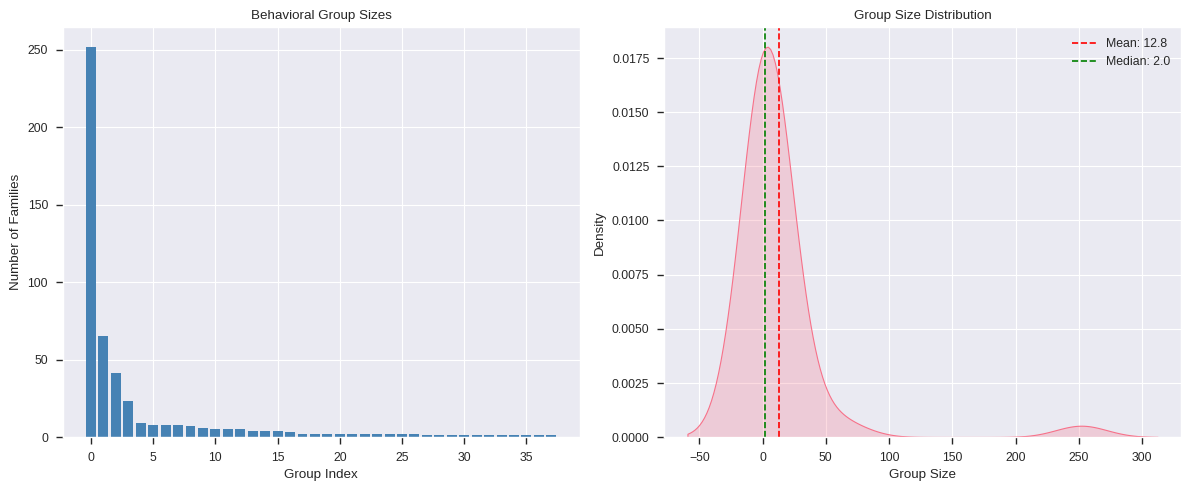

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import json

def analyze_groups():
    # Load data
    with open('/data/saranyav/gcn_new/behavioral_analysis/behavioral_groups.json') as f:
        groups = json.load(f)
    
    sizes = [len(families) for families in groups.values()]
    
    # Plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot of sizes
    sorted_sizes = sorted(sizes, reverse=True) 
    ax1.bar(range(len(sorted_sizes)), sorted_sizes, color='steelblue')
    ax1.set_xlabel('Group Index')
    ax1.set_ylabel('Number of Families')
    ax1.set_title('Behavioral Group Sizes')

    # Size distribution
    sns.kdeplot(data=sizes, ax=ax2, fill=True)
    ax2.axvline(np.mean(sizes), color='r', linestyle='--', label=f'Mean: {np.mean(sizes):.1f}')
    ax2.axvline(np.median(sizes), color='g', linestyle='--', label=f'Median: {np.median(sizes):.1f}')
    ax2.set_xlabel('Group Size')
    ax2.set_ylabel('Density')
    ax2.set_title('Group Size Distribution')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

analyze_groups()

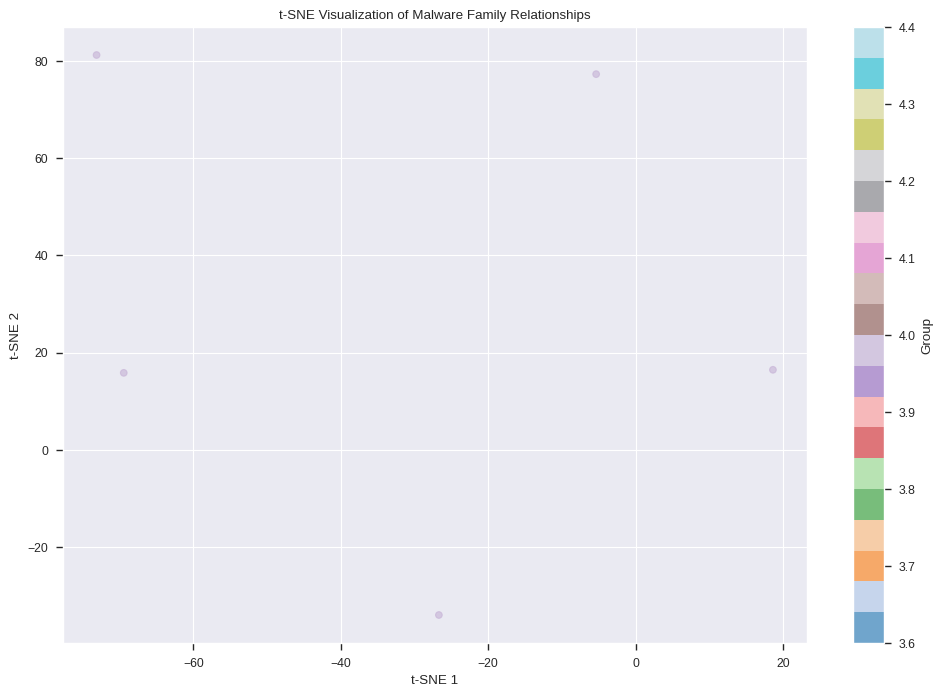

In [40]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import json

def analyze_clustering():
   # Load data
   similarity_matrix = np.load('/data/saranyav/gcn_new/behavioral_analysis/similarity_matrix.npy')
   with open('/data/saranyav/gcn_new/behavioral_analysis/behavioral_groups.json') as f:
       groups = json.load(f)
   
   # Create labels array
   n = len(similarity_matrix) 
   labels = np.zeros(n)
   
   family_idx = 0
   for group_id, families in groups.items():
       for _ in families:
           if family_idx < n:
               labels[family_idx] = int(group_id)
               family_idx += 1
   
   # TSNE 
   distance_matrix = 1 - similarity_matrix
   tsne = TSNE(n_components=2,
               metric='precomputed',
               perplexity=min(30, n-1),
               init='random',
               random_state=42)
   embedding = tsne.fit_transform(distance_matrix)
   
   # Plot
   plt.figure(figsize=(12, 8))
   scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                        c=labels[:len(embedding)], 
                        cmap='tab20',
                        alpha=0.6)
   plt.title('t-SNE Visualization of Malware Family Relationships')
   plt.xlabel('t-SNE 1')
   plt.ylabel('t-SNE 2')
   plt.colorbar(scatter, label='Group')
   plt.show()

analyze_clustering()

In [16]:
# count how many keys in class_distribution
num_classes = len(class_distribution.keys())
num_classes

487

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from pathlib import Path
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
from typing import Dict, List


class MalwareBehaviorVisualizer:
    def __init__(self, data_dir: str = '/data/saranyav/gcn_new/behavioral_analysis'):
        self.data_dir = Path(data_dir)
        # Set style
        plt.style.use('seaborn')
        sns.set_palette("husl")
        
    def load_data_from_aggregator(self, aggregator):
        """Load data directly from MalwareBehaviorAggregator instance."""
        self.family_distributions = aggregator.family_distributions
        self.groups, self.similarity_matrix = aggregator.create_behavioral_groups()
        
    def load_data_from_files(self):
        """Load previously saved data from files."""
        self.similarity_matrix = np.load(self.data_dir / 'similarity_matrix.npy')
        with open(self.data_dir / 'behavioral_groups.json', 'r') as f:
            self.groups = json.load(f)
            
    def plot_similarity_heatmap(self, figsize=(12, 10)):
        """Plot similarity matrix heatmap."""
        plt.figure(figsize=figsize)
        sns.heatmap(self.similarity_matrix, 
                   cmap='viridis',
                   xticklabels=False, 
                   yticklabels=False)
        plt.title('Family Similarity Matrix')
        plt.xlabel('Family Index')
        plt.ylabel('Family Index')
        plt.show()
        
    def plot_group_sizes(self, figsize=(10, 6)):
        """Plot distribution of behavioral group sizes."""
        group_sizes = [len(families) for families in self.groups.values()]
        
        plt.figure(figsize=figsize)
        sns.histplot(group_sizes, bins=20)
        plt.title('Distribution of Behavioral Group Sizes')
        plt.xlabel('Number of Families in Group')
        plt.ylabel('Count')
        plt.show()
        
        # Box plot
        plt.figure(figsize=figsize)
        sns.boxplot(x=group_sizes)
        plt.title('Behavioral Group Size Distribution')
        plt.xlabel('Group Size')
        plt.show()
        
    def plot_silhouette_analysis(self, n_clusters_range=range(2, 11)):
        """Plot silhouette analysis for different numbers of clusters."""
        plt.figure(figsize=(10, 6))
        
        silhouette_scores = []
        for n_clusters in n_clusters_range:
            # Compute silhouette score using distance matrix (1 - similarity)
            distance_matrix = 1 - self.similarity_matrix
            from sklearn.cluster import AgglomerativeClustering
            
            clustering = AgglomerativeClustering(
                n_clusters=n_clusters,
                metric='precomputed',
                linkage='average'
            )
            labels = clustering.fit_predict(distance_matrix)
            score = silhouette_score(distance_matrix, labels, metric='precomputed')
            silhouette_scores.append(score)
        
        plt.plot(n_clusters_range, silhouette_scores, 'bo-')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.grid(True)
        plt.show()
        
    def plot_feature_distributions(self, family_distributions: Dict, features: List[str] = None):
        """Plot feature distributions across families."""
        if features is None:
            features = ['mem_ops', 'calls', 'instructions', 'stack_ops']
            
        n_features = len(features)
        fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
        
        for idx, feature in enumerate(features):
            feature_data = []
            for family, dist in family_distributions.items():
                if 'feature_stats' in dist and feature in dist['feature_stats']:
                    hist = dist['feature_stats'][feature]['histogram']
                    feature_data.append(hist)
            
            if feature_data:
                # Plot average distribution
                mean_dist = np.mean(feature_data, axis=0)
                std_dist = np.std(feature_data, axis=0)
                x = range(len(mean_dist))
                
                axes[idx].plot(x, mean_dist, 'b-', label='Mean')
                axes[idx].fill_between(x, 
                                     mean_dist - std_dist,
                                     mean_dist + std_dist,
                                     alpha=0.3,
                                     label='±1 std')
                axes[idx].set_title(f'{feature} Distribution')
                axes[idx].legend()
                
        plt.tight_layout()
        plt.show()
        
    def plot_behavior_patterns(self, family_distributions: Dict):
        """Plot common behavior patterns across families."""
        patterns = ['ext_call', 'mem_rw', 'cond_jump', 'ext_write']
        
        pattern_data = []
        for family, dist in family_distributions.items():
            if 'behavior_patterns' in dist:
                family_patterns = []
                for pattern in patterns:
                    value = dist['behavior_patterns'].get(pattern, 0)
                    family_patterns.append(value)
                pattern_data.append(family_patterns)
                
        if pattern_data:
            pattern_data = np.array(pattern_data)
            
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=pd.DataFrame(pattern_data, columns=patterns))
            plt.title('Distribution of Behavior Patterns')
            plt.xticks(rotation=45)
            plt.ylabel('Frequency')
            plt.show()
            
    def plot_structural_features(self, family_distributions: Dict):
        """Plot structural features across families."""
        structures = ['branching_nodes', 'merge_nodes', 'terminal_nodes',
                     'isolated_nodes', 'dense_regions']
        
        struct_data = []
        for family, dist in family_distributions.items():
            if 'local_structures' in dist:
                family_structs = []
                for struct in structures:
                    value = dist['local_structures'].get(struct, 0)
                    family_structs.append(value)
                struct_data.append(family_structs)
                
        if struct_data:
            struct_data = np.array(struct_data)
            
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=pd.DataFrame(struct_data, columns=structures))
            plt.title('Distribution of Structural Features')
            plt.xticks(rotation=45)
            plt.ylabel('Frequency')
            plt.show()

# Usage example:
# visualizer = MalwareBehaviorVisualizer()
# visualizer.plot_similarity_heatmap()
# visualizer.plot_group_sizes()
# visualizer.plot_silhouette_analysis()
# visualizer.plot_feature_distributions(family_distributions)
# visualizer.plot_behavior_patterns(family_distributions)
# visualizer.plot_structural_features(family_distributions)

2025-01-03 16:41:22,817 - INFO - Loading batches from /data/saranyav/gcn_new/bodmas_batches_new/train
Loading batches:   0%|          | 0/352 [00:00<?, ?it/s]/data/saranyav/gcn_new/Processing/family_aggregator.py:407: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded f

Number of family_distributions
488
Number of family_graphs
488

Found 13 malware types
trojan: 311 families
worm: 77 families
ransomware: 16 families
informationstealer: 15 families
dropper: 10 families
backdoor: 32 families
virus: 7 families
downloader: 10 families
trojan-gamethief: 1 families
cryptominer: 2 families
pua: 5 families
exploit: 1 families
rootkit: 1 families

Processing malware type: trojan

Processing malware type: worm

Processing malware type: ransomware

Processing malware type: informationstealer

Processing malware type: dropper

Processing malware type: backdoor

Processing malware type: virus

Processing malware type: downloader

Processing malware type: trojan-gamethief

Processing malware type: cryptominer

Processing malware type: pua

Processing malware type: exploit

Processing malware type: rootkit

Created 38 behavioral groups:

Group 2: 6 families
Sample families: wacatac, upatre, gepys, quasarrat, vbclone...

Group 4: 239 families
Sample families: small,

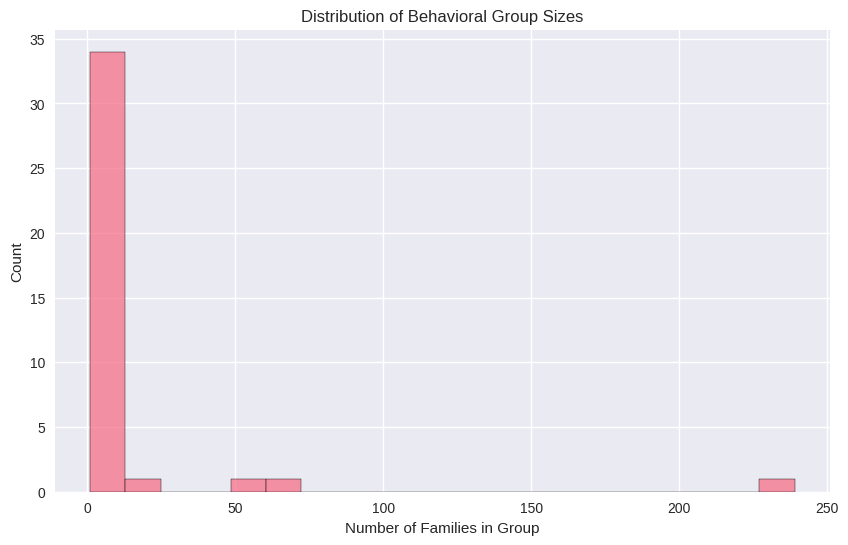

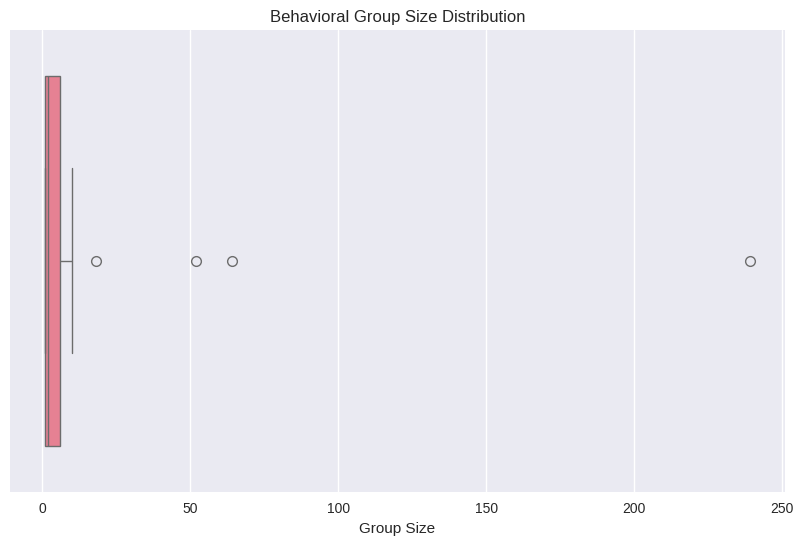

ValueError: The precomputed distance matrix contains non-zero elements on the diagonal. Use np.fill_diagonal(X, 0).

<Figure size 1000x600 with 0 Axes>

In [32]:
# from paste_2 import MalwareBehaviorAggregator  # Your second file
# from /data/saranyav/gcn_new/Processing/ import MalwareBehaviorAggregator
import sys
sys.path.append('/data/saranyav/gcn_new/Processing/')
from family_aggregator import MalwareBehaviorAggregator

# Initialize and load data
aggregator = MalwareBehaviorAggregator(batch_dir=Path('/data/saranyav/gcn_new/bodmas_batches_new'))
aggregator.load_processed_batches(split='train')
aggregator.process_families()

visualizer = MalwareBehaviorVisualizer()
visualizer.load_data_from_aggregator(aggregator)
visualizer.plot_group_sizes()
visualizer.plot_silhouette_analysis()
visualizer.plot_feature_distributions(visualizer.family_distributions)
visualizer.plot_behavior_patterns(visualizer.family_distributions)
visualizer.plot_structural_features(visualizer.family_distributions)

# # Initialize visualizer with data from aggregator
# visualizer = MalwareBehaviorVisualizer()
# visualizer.load_data_from_aggregator(aggregator)

# # Create visualizations
# visualizer.plot_similarity_heatmap()
# visualizer.plot_feature_distributions(visualizer.family_distributions)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import Dict, List

class MalwareMetricsVisualizer2:
    def __init__(self):
        plt.style.use('seaborn')
        sns.set_palette("deep")
        plt.rcParams['figure.figsize'] = [12, 6]
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['axes.labelsize'] = 12
        
    def load_data_from_aggregator(self, aggregator):
        """Load data directly from MalwareBehaviorAggregator instance."""
        self.family_distributions = aggregator.family_distributions
        self.family_graphs = aggregator.family_graphs
        
    def plot_call_patterns(self):
        """Analyze internal vs external call patterns."""
        call_data = defaultdict(list)
        
        for family, dist in self.family_distributions.items():
            if 'feature_stats' in dist:
                # Get internal and external call metrics
                internal_calls = np.mean(dist['feature_stats'].get('internal_calls', {}).get('histogram', [0]))
                external_calls = np.mean(dist['feature_stats'].get('external_calls', {}).get('histogram', [0]))
                total_calls = internal_calls + external_calls
                
                if total_calls > 0:  # Only include families with calls
                    call_data['family'].append(family)
                    call_data['internal_calls'].append(internal_calls)
                    call_data['external_calls'].append(external_calls)
                    call_data['total_calls'].append(total_calls)
                    # Calculate percentages
                    call_data['internal_pct'].append((internal_calls/total_calls) * 100)
                    call_data['external_pct'].append((external_calls/total_calls) * 100)
                    # Calculate call ratios
                    call_data['ext_to_int_ratio'].append(external_calls/internal_calls if internal_calls > 0 else float('inf'))
        
        if call_data:
            df = pd.DataFrame(call_data)
            
            # 1. Scatter plot of internal vs external calls
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=df, x='internal_calls', y='external_calls', alpha=0.6)
            plt.title('Internal vs External Call Distribution')
            plt.xlabel('Average Internal Calls per Block')
            plt.ylabel('Average External Calls per Block')
            # Add trend line
            sns.regplot(data=df, x='internal_calls', y='external_calls', 
                       scatter=False, color='red', line_kws={'linestyle': '--'})
            plt.tight_layout()
            plt.show()

            # 2. Top 20 families by total calls, showing internal/external split
            top_20 = df.nlargest(20, 'total_calls')
            plt.figure(figsize=(15, 6))
            
            x = range(len(top_20))
            plt.bar(x, top_20['internal_calls'], label='Internal Calls')
            plt.bar(x, top_20['external_calls'], bottom=top_20['internal_calls'], 
                   label='External Calls')
            
            plt.title('Call Distribution for Top 20 Most Call-Heavy Families')
            plt.xlabel('Family')
            plt.ylabel('Number of Calls')
            plt.legend()
            plt.xticks(x, top_20['family'], rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # 3. Distribution of internal vs external call ratios
            plt.figure(figsize=(12, 6))
            ratios = df['ext_to_int_ratio'].replace([float('inf')], df['ext_to_int_ratio'].max())
            sns.histplot(ratios, bins=50)
            plt.title('Distribution of External/Internal Call Ratios')
            plt.xlabel('External/Internal Call Ratio')
            plt.ylabel('Count')
            # Add vertical line for 1:1 ratio
            plt.axvline(x=1, color='r', linestyle='--', label='1:1 Ratio')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # 4. Boxplot comparing internal and external call distributions
            plt.figure(figsize=(8, 6))
            df_melted = df.melt(id_vars=['family'], 
                              value_vars=['internal_calls', 'external_calls'],
                              var_name='call_type', value_name='count')
            sns.boxplot(data=df_melted, x='call_type', y='count')
            plt.title('Distribution of Call Types')
            plt.ylabel('Number of Calls')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
    def plot_complexity_metrics(self):
        """Visualize complexity metrics across families."""
        metrics = defaultdict(list)
        
        for family, dist in self.family_distributions.items():
            if 'feature_stats' in dist:
                metrics['family'].append(family)
                # Get average instruction count
                instr_hist = dist['feature_stats'].get('instructions', {}).get('histogram', [0])
                metrics['avg_instructions'].append(np.mean(instr_hist) if instr_hist else 0)
                # Get branching complexity
                branch_hist = dist['feature_stats'].get('has_jump', {}).get('histogram', [0])
                metrics['branching_complexity'].append(np.mean(branch_hist) if branch_hist else 0)
                
        if metrics:
            df = pd.DataFrame(metrics)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Distribution of instruction counts
            sns.histplot(data=df, x='avg_instructions', bins=30, ax=ax1)
            ax1.set_title('Distribution of Average Instructions per Block')
            ax1.set_xlabel('Average Instructions')
            
            # Scatter plot of instructions vs branching
            sns.scatterplot(data=df, x='avg_instructions', y='branching_complexity', ax=ax2)
            ax2.set_title('Instructions vs Branching Complexity')
            ax2.set_xlabel('Average Instructions')
            ax2.set_ylabel('Branching Complexity')
            
            plt.tight_layout()
            plt.show()
            
    def plot_memory_behavior(self):
        """Analyze and plot memory operation patterns."""
        mem_data = defaultdict(list)
        
        for family, dist in self.family_distributions.items():
            if 'feature_stats' in dist:
                reads = np.mean(dist['feature_stats'].get('mem_reads', {}).get('histogram', [0]))
                writes = np.mean(dist['feature_stats'].get('mem_writes', {}).get('histogram', [0]))
                if reads > 0 or writes > 0:  # Only include families with memory operations
                    mem_data['family'].append(family)
                    mem_data['reads'].append(reads)
                    mem_data['writes'].append(writes)
                    mem_data['ratio'].append(writes/reads if reads > 0 else 0)
        
        if mem_data:
            df = pd.DataFrame(mem_data)
            df = df.sort_values('ratio', ascending=False)
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
            
            # Scatter plot of reads vs writes
            sns.scatterplot(data=df, x='reads', y='writes', ax=ax1)
            ax1.set_title('Memory Reads vs Writes Pattern')
            ax1.set_xlabel('Average Memory Reads per Block')
            ax1.set_ylabel('Average Memory Writes per Block')
            
            # Top 20 families by read/write ratio
            top_20 = df.head(20)
            sns.barplot(data=top_20, x='family', y='ratio', ax=ax2)
            ax2.set_title('Top 20 Families by Write/Read Ratio')
            ax2.set_xlabel('Family')
            ax2.set_ylabel('Write/Read Ratio')
            plt.xticks(rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()
            
    def plot_control_flow_patterns(self):
        """Analyze control flow characteristics."""
        flow_data = defaultdict(list)
        
        for family, dist in self.family_distributions.items():
            if 'feature_stats' in dist:
                flow_data['family'].append(family)
                # Get conditional branch frequency
                cond = np.mean(dist['feature_stats'].get('is_conditional', {}).get('histogram', [0]))
                flow_data['conditional_branches'].append(cond)
                # Get jump frequency
                jumps = np.mean(dist['feature_stats'].get('has_jump', {}).get('histogram', [0]))
                flow_data['jumps'].append(jumps)
                # Get return frequency
                rets = np.mean(dist['feature_stats'].get('has_ret', {}).get('histogram', [0]))
                flow_data['returns'].append(rets)
        
        if flow_data:
            df = pd.DataFrame(flow_data)
            
            # Melt the dataframe for better visualization
            df_melted = df.melt(id_vars=['family'], 
                              value_vars=['conditional_branches', 'jumps', 'returns'],
                              var_name='flow_type', value_name='frequency')
            
            plt.figure(figsize=(15, 6))
            sns.boxplot(data=df_melted, x='flow_type', y='frequency')
            plt.title('Distribution of Control Flow Characteristics')
            plt.xlabel('Type of Control Flow')
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()
            
            # Show top families for each type
            fig, axes = plt.subplots(1, 3, figsize=(20, 6))
            for i, col in enumerate(['conditional_branches', 'jumps', 'returns']):
                top_10 = df.nlargest(10, col)
                sns.barplot(data=top_10, x='family', y=col, ax=axes[i])
                axes[i].set_title(f'Top 10 Families by {col.replace("_", " ").title()}')
                axes[i].tick_params(axis='x', rotation=45)
            plt.tight_layout()
            plt.show()
            
    def plot_instruction_patterns(self):
        """Analyze instruction mix patterns."""
        instr_data = defaultdict(list)
        
        for family, dist in self.family_distributions.items():
            if 'feature_stats' in dist:
                instr_data['family'].append(family)
                # Get different instruction type frequencies
                stack = np.mean(dist['feature_stats'].get('stack_ops', {}).get('histogram', [0]))
                reg = np.mean(dist['feature_stats'].get('reg_writes', {}).get('histogram', [0]))
                mem = np.mean(dist['feature_stats'].get('mem_ops', {}).get('histogram', [0]))
                calls = np.mean(dist['feature_stats'].get('calls', {}).get('histogram', [0]))
                
                instr_data['stack_ops'].append(stack)
                instr_data['register_ops'].append(reg)
                instr_data['memory_ops'].append(mem)
                instr_data['call_ops'].append(calls)
                
                # Calculate instruction mix percentages
                total = stack + reg + mem + calls
                if total > 0:
                    instr_data['stack_pct'].append(stack/total * 100)
                    instr_data['register_pct'].append(reg/total * 100)
                    instr_data['memory_pct'].append(mem/total * 100)
                    instr_data['call_pct'].append(calls/total * 100)
                else:
                    instr_data['stack_pct'].append(0)
                    instr_data['register_pct'].append(0)
                    instr_data['memory_pct'].append(0)
                    instr_data['call_pct'].append(0)
        
        if instr_data:
            df = pd.DataFrame(instr_data)
            
            # Plot raw instruction counts
            plt.figure(figsize=(15, 6))
            data_to_plot = df[['stack_ops', 'register_ops', 'memory_ops', 'call_ops']]
            sns.boxplot(data=data_to_plot)
            plt.title('Distribution of Instruction Types')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Plot instruction mix percentages for top 20 families by total instructions
            df['total_ops'] = df[['stack_ops', 'register_ops', 'memory_ops', 'call_ops']].sum(axis=1)
            top_20 = df.nlargest(20, 'total_ops')
            
            plt.figure(figsize=(15, 6))
            bottom = np.zeros(20)
            
            for op in ['stack_pct', 'register_pct', 'memory_pct', 'call_pct']:
                plt.bar(range(20), top_20[op], bottom=bottom, label=op.replace('_pct', ''))
                bottom += top_20[op]
                
            plt.title('Instruction Mix for Top 20 Most Complex Families')
            plt.xlabel('Family')
            plt.ylabel('Percentage')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(range(20), top_20['family'], rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

In [21]:
import json
import torch
import numpy as np
import pandas as pd
from pathlib import Path

def create_behavioral_features_table(batch_dir, groups_path):
    # Load behavioral groups
    with open(groups_path) as f:
        groups = json.load(f)
    
    # Initialize feature storage per group
    group_features = {}
    
    # Process each batch file
    for split in ['train', 'val', 'test']:
        batch_dir_path = Path(batch_dir) / split
        for batch_file in batch_dir_path.glob('batch_*.pt'):
            graphs = torch.load(batch_file)
            
            for graph in graphs:
                family = graph.family.lower()
                group_id = next((gid for gid, families in groups.items() 
                               if family in families), None)
                
                if group_id is not None:
                    if group_id not in group_features:
                        group_features[group_id] = {
                            'reg_writes_max': [],
                            'reg_writes_mean': [],
                            'external_calls_ratio': [],
                            'is_conditional_ratio': [],
                            'avg_degree': [],
                            'max_degree': [],
                            'n_samples': 0,
                            'total_nodes': 0,
                            'total_edges': 0
                        }
                    
                    # Extract features
                    features = graph.x.numpy()
                    
                    # Register writes
                    reg_writes = features[:, 4]  # reg_writes column
                    group_features[group_id]['reg_writes_max'].append(np.max(reg_writes))
                    group_features[group_id]['reg_writes_mean'].append(np.mean(reg_writes))
                    
                    # External calls ratio
                    n_external = np.count_nonzero(features[:, 5])  # external_calls column
                    group_features[group_id]['external_calls_ratio'].append(n_external / len(features))
                    
                    # Conditional instructions ratio
                    n_conditional = np.count_nonzero(features[:, 11])  # is_conditional column
                    group_features[group_id]['is_conditional_ratio'].append(n_conditional / len(features))
                    
                    # Compute actual degrees from edge_index
                    n_nodes = graph.num_nodes
                    edge_index = graph.edge_index.numpy()
                    
                    in_degrees = np.bincount(edge_index[1], minlength=n_nodes)
                    out_degrees = np.bincount(edge_index[0], minlength=n_nodes)
                    total_degrees = in_degrees + out_degrees
                    
                    group_features[group_id]['avg_degree'].append(np.mean(total_degrees))
                    group_features[group_id]['max_degree'].append(np.max(total_degrees))
                    
                    # Update counts
                    group_features[group_id]['n_samples'] += 1
                    group_features[group_id]['total_nodes'] += n_nodes
                    group_features[group_id]['total_edges'] += len(edge_index[0])
    
    # Create summary statistics
    stats = []
    for group_id, features in group_features.items():
        if len(groups[group_id]) >= 5:  # Only include groups with 5+ families
            row = {
                'Group': f'G{group_id}',
                'Size': len(groups[group_id]),
                'Samples': features['n_samples'],
                'Avg Nodes': features['total_nodes'] / features['n_samples'],
                'Avg Edges': features['total_edges'] / features['n_samples'],
                'Reg Writes (max)': np.mean(features['reg_writes_max']),
                'Reg Writes (mean)': np.mean(features['reg_writes_mean']),
                'Ext Calls %': np.mean(features['external_calls_ratio']) * 100,
                'Cond Instr %': np.mean(features['is_conditional_ratio']) * 100,
                'Avg Degree': np.mean(features['avg_degree']),
                'Max Degree': np.mean(features['max_degree'])
            }
            stats.append(row)
    
    # Create DataFrame and sort by size
    df = pd.DataFrame(stats)
    df = df.sort_values('Size', ascending=False)
    
    # Format number function
    def format_number(x, col):
        if isinstance(x, str):
            return x
        if col == 'Size' or col == 'Samples':
            return f"{int(x):,d}"
        if col in ['Avg Nodes', 'Avg Edges']:
            return f"{x:,.0f}"
        if col.startswith('Ext') or col.startswith('Cond'):
            return f"{x:.2f}\\%"
        if 'max' in col.lower():
            return f"{x:.1f}"
        return f"{x:.2f}"
    
    # Create LaTeX table
    latex_code = "\\begin{table}[t]\n\\centering\n"
    latex_code += "\\caption{Behavioral Group Characteristics (Groups with 5+ Families)}\n"
    latex_code += "\\label{tab:group-features}\n"
    latex_code += "\\resizebox{\\textwidth}{!}{\n"
    latex_code += "\\begin{tabular}{l|ccc|cc|ccc|cc}\n\\hline\n"
    latex_code += "Group & Size & Samples & Avg Nodes & "
    latex_code += "Reg Max & Reg Mean & Ext\\% & Cond\\% & "
    latex_code += "Avg Deg & Max Deg \\\\\n\\hline\n"
    
    for _, row in df.iterrows():
        line = [
            row['Group'],
            format_number(row['Size'], 'Size'),
            format_number(row['Samples'], 'Samples'),
            format_number(row['Avg Nodes'], 'Avg Nodes'),
            format_number(row['Reg Writes (max)'], 'max'),
            format_number(row['Reg Writes (mean)'], 'mean'),
            format_number(row['Ext Calls %'], 'Ext'),
            format_number(row['Cond Instr %'], 'Cond'),
            format_number(row['Avg Degree'], 'avg'),
            format_number(row['Max Degree'], 'max')
        ]
        latex_code += " & ".join(line) + " \\\\\n"
    
    latex_code += "\\hline\n\\end{tabular}\n}\n\\end{table}"
    
    # Save to file
    with open('behavioral_features_fixed.tex', 'w') as f:
        f.write(latex_code)
        
    return df

if __name__ == "__main__":
    df = create_behavioral_features_table(
        'bodmas_batches_new',
        '/data/saranyav/gcn_new/behavioral_analysis/behavioral_groups.json'
    )
    print("\nDataFrame view:")
    print(df)

KeyError: 'Size'

/tmp/ipykernel_3617541/352043580.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


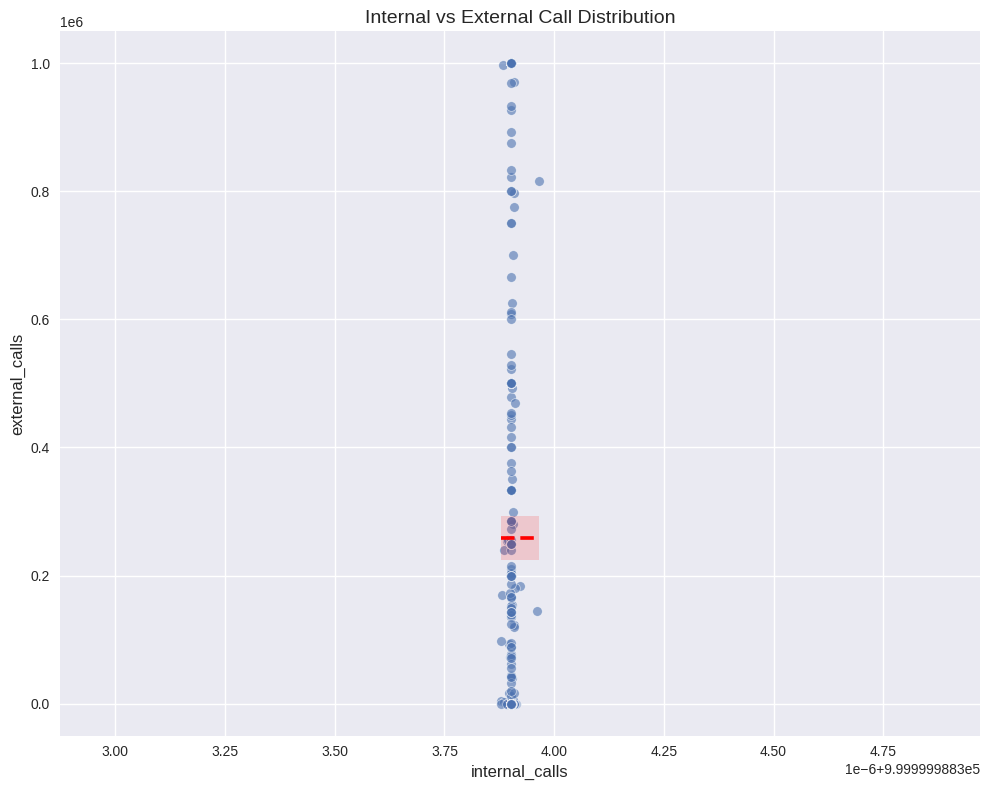

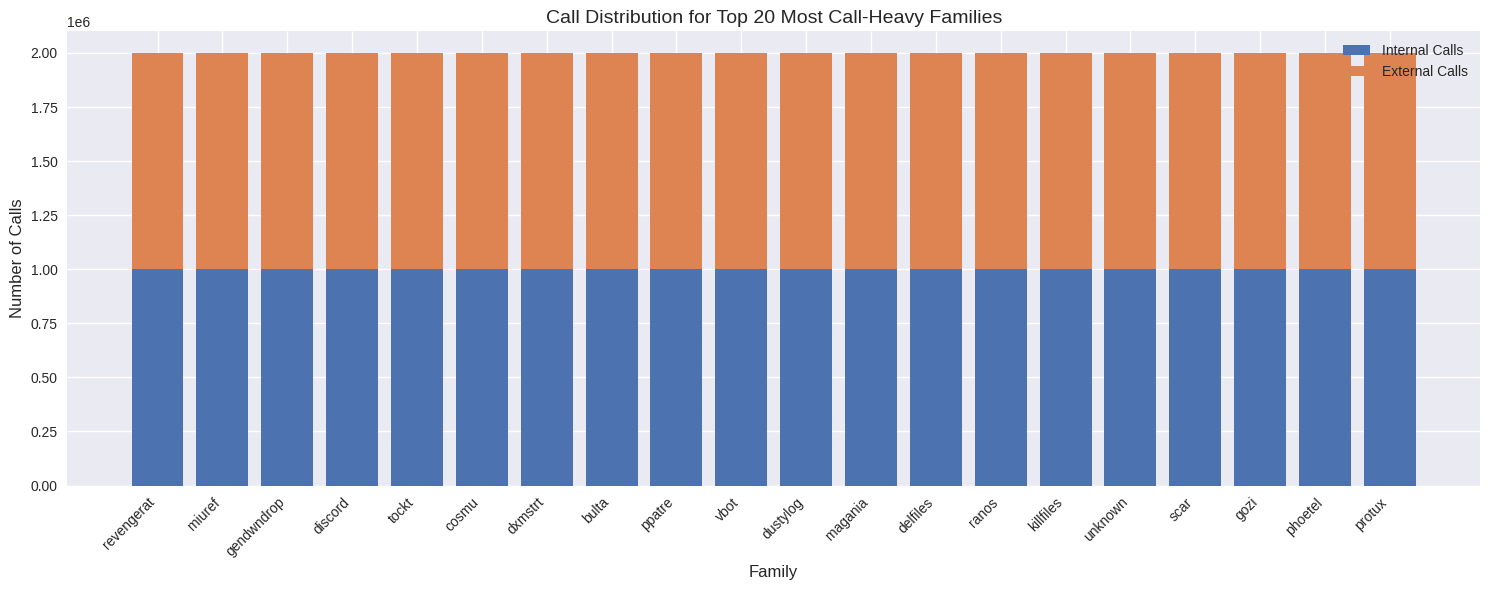

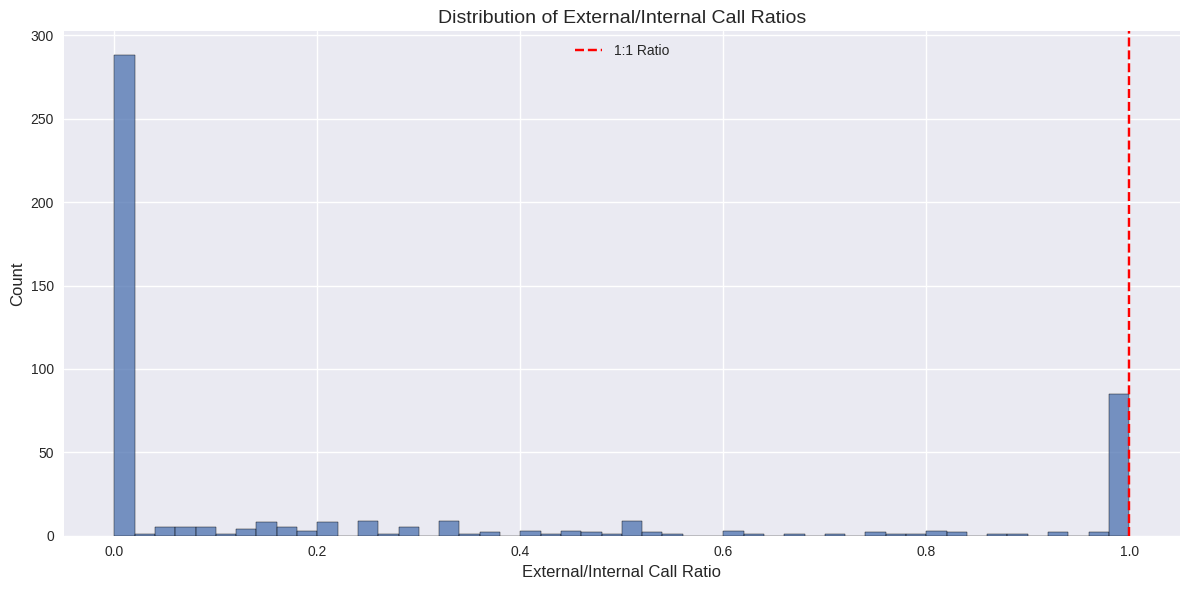

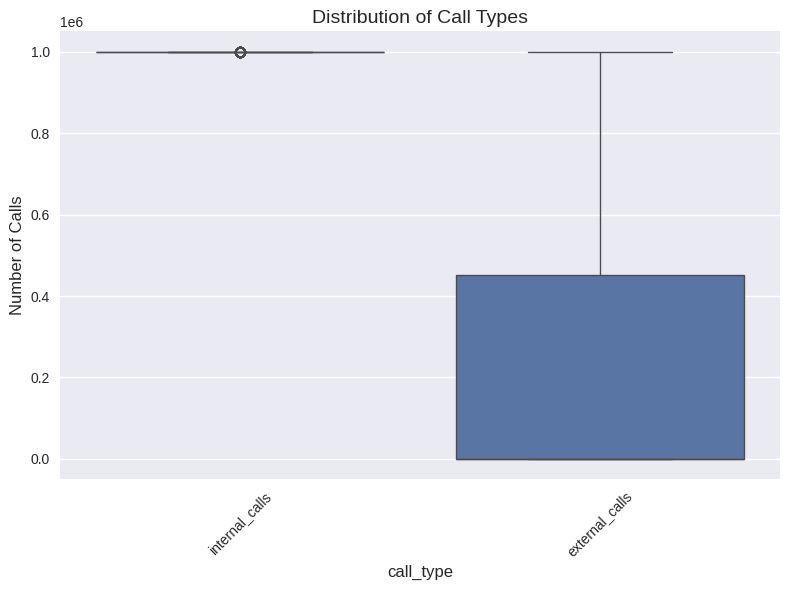

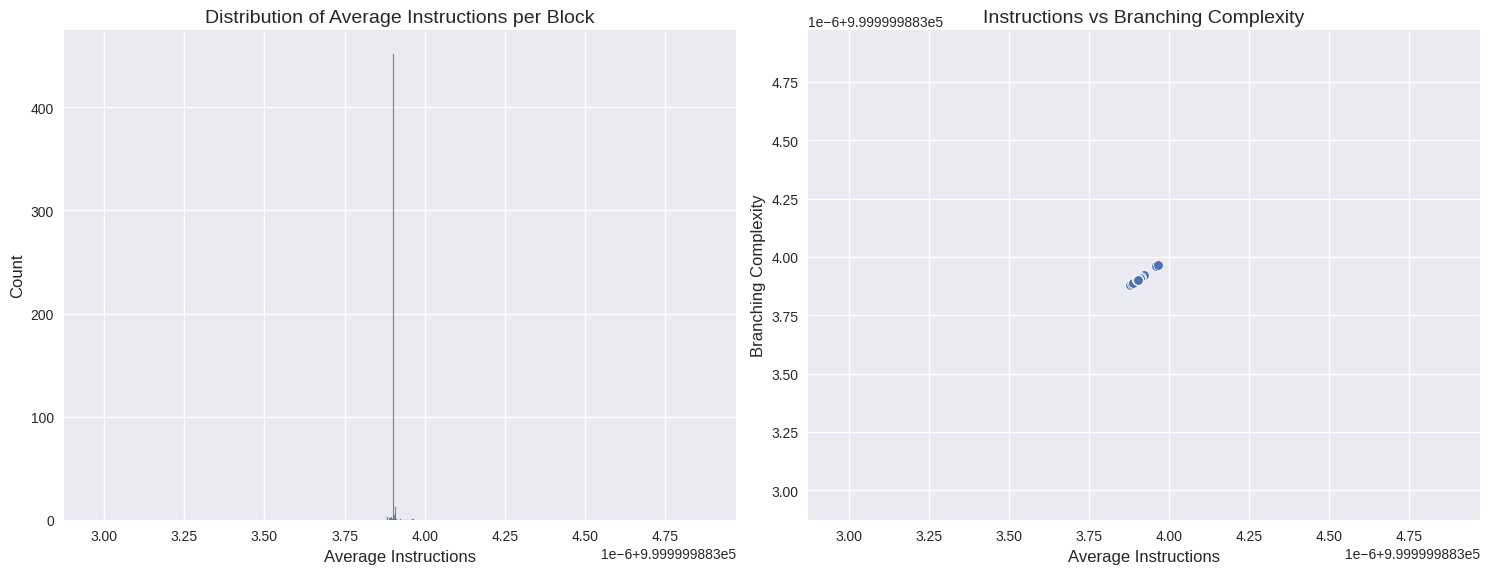

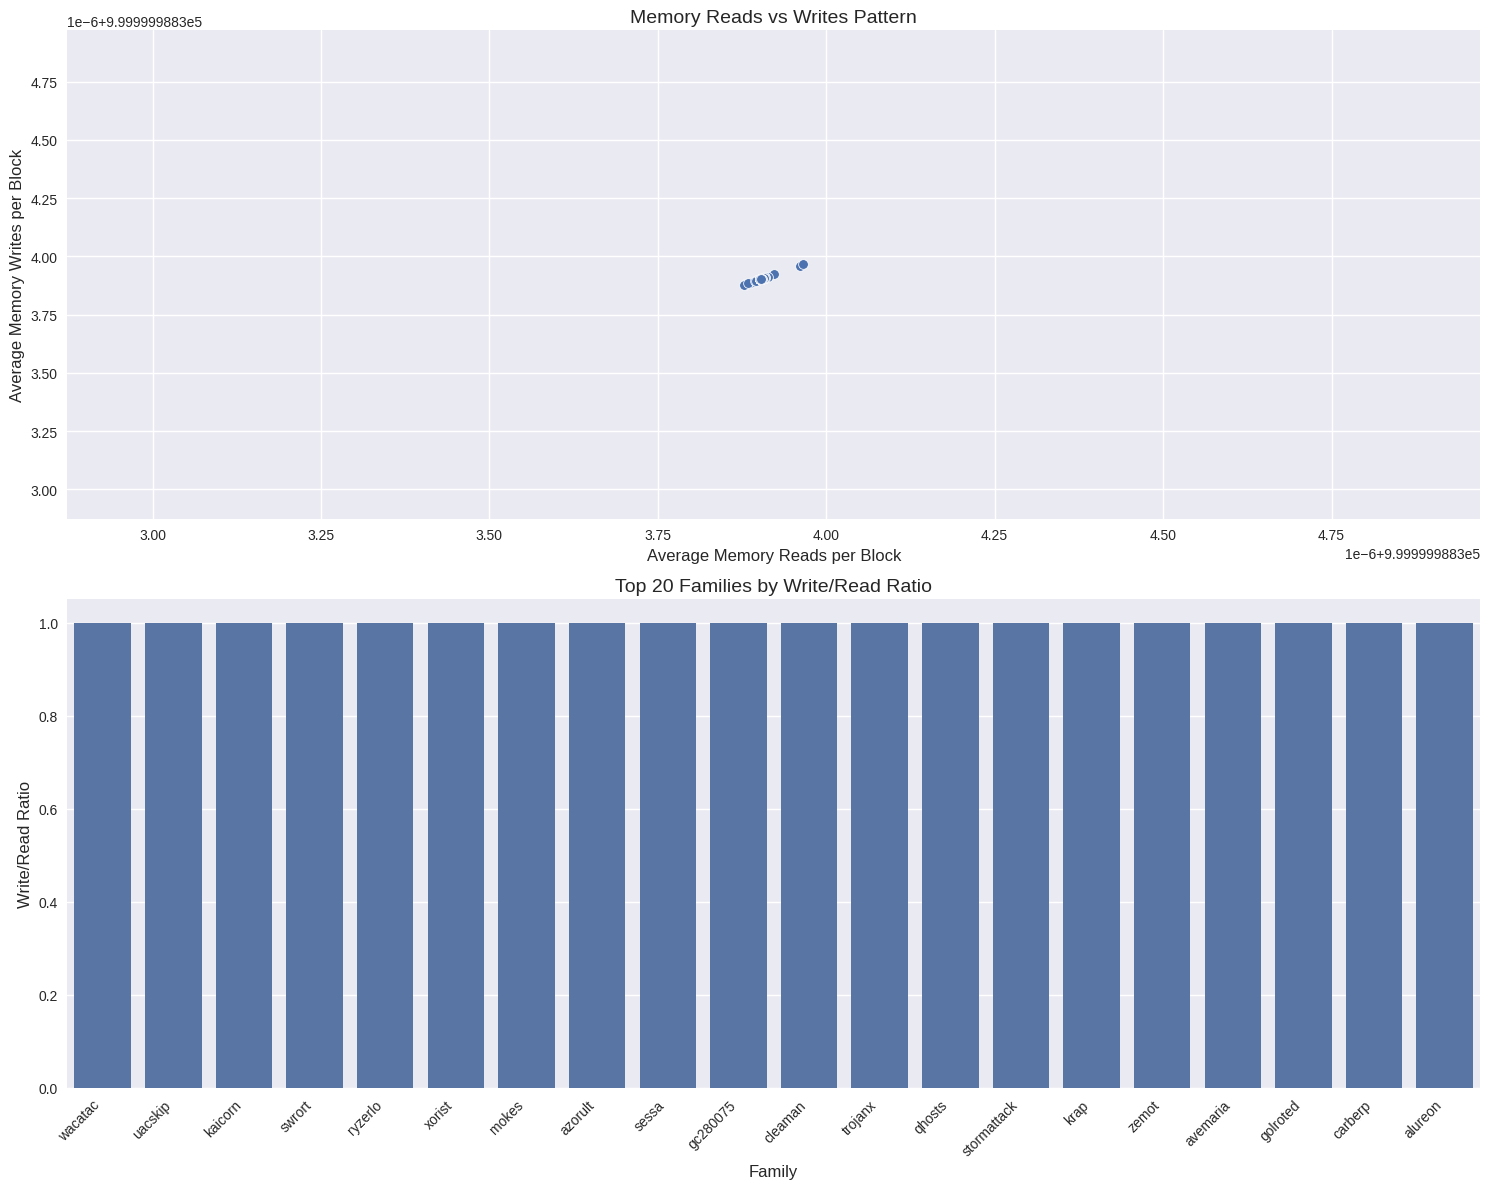

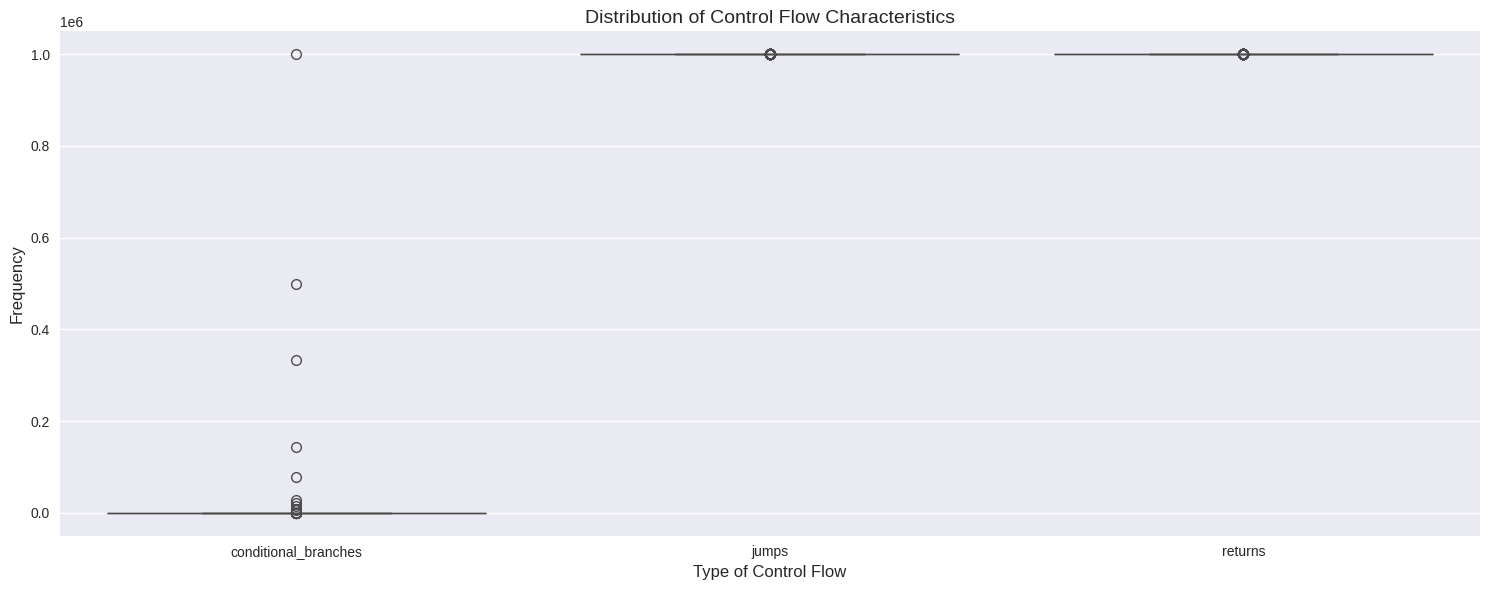

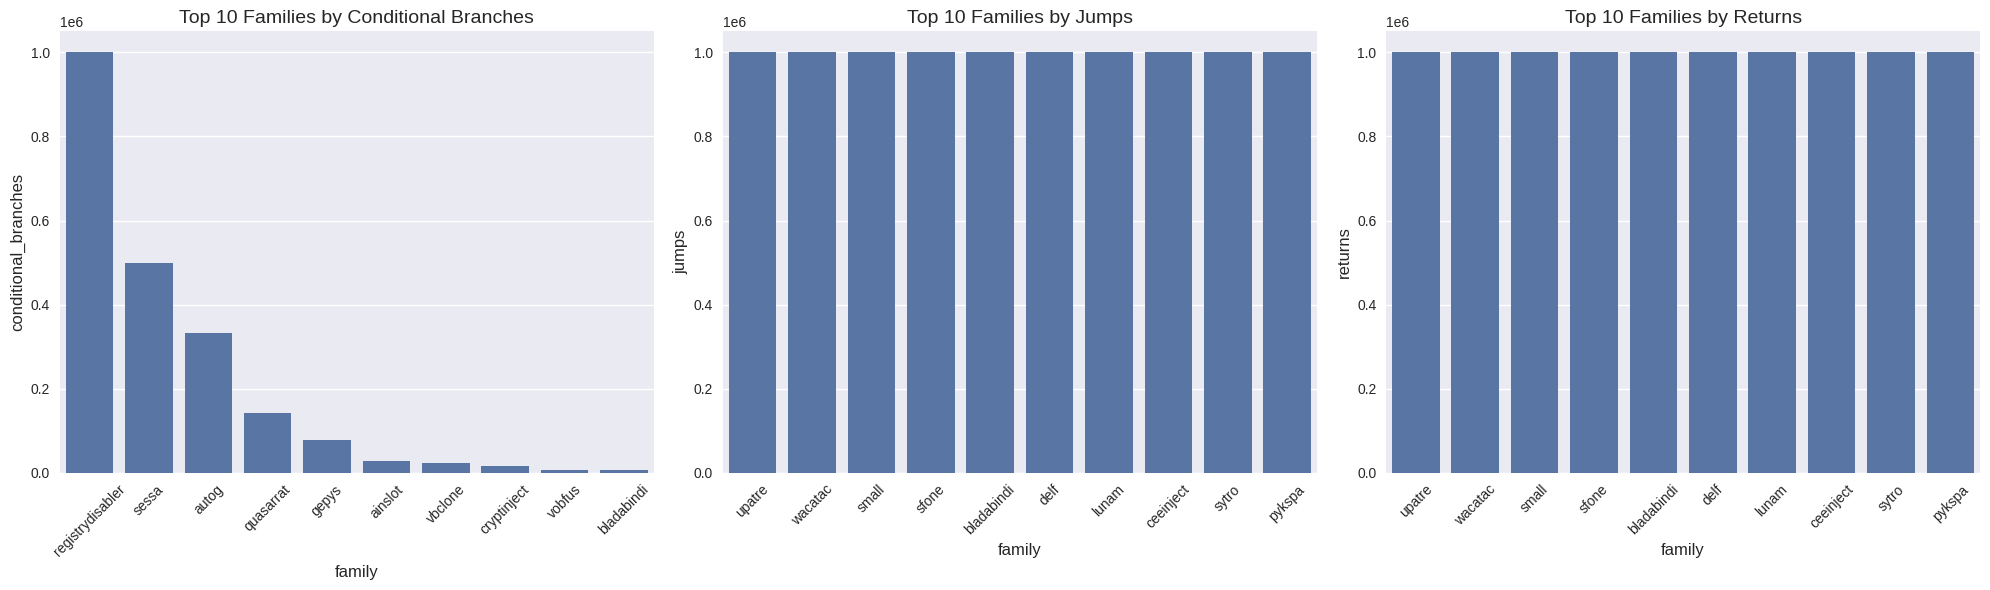

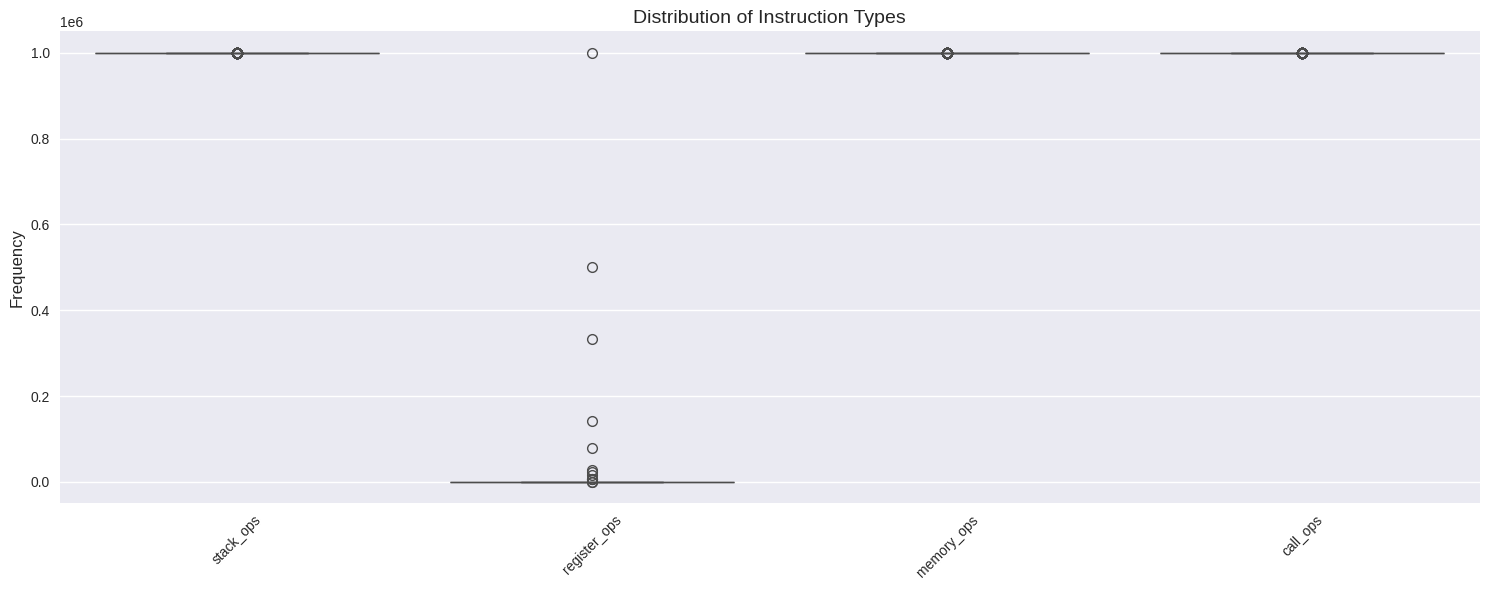

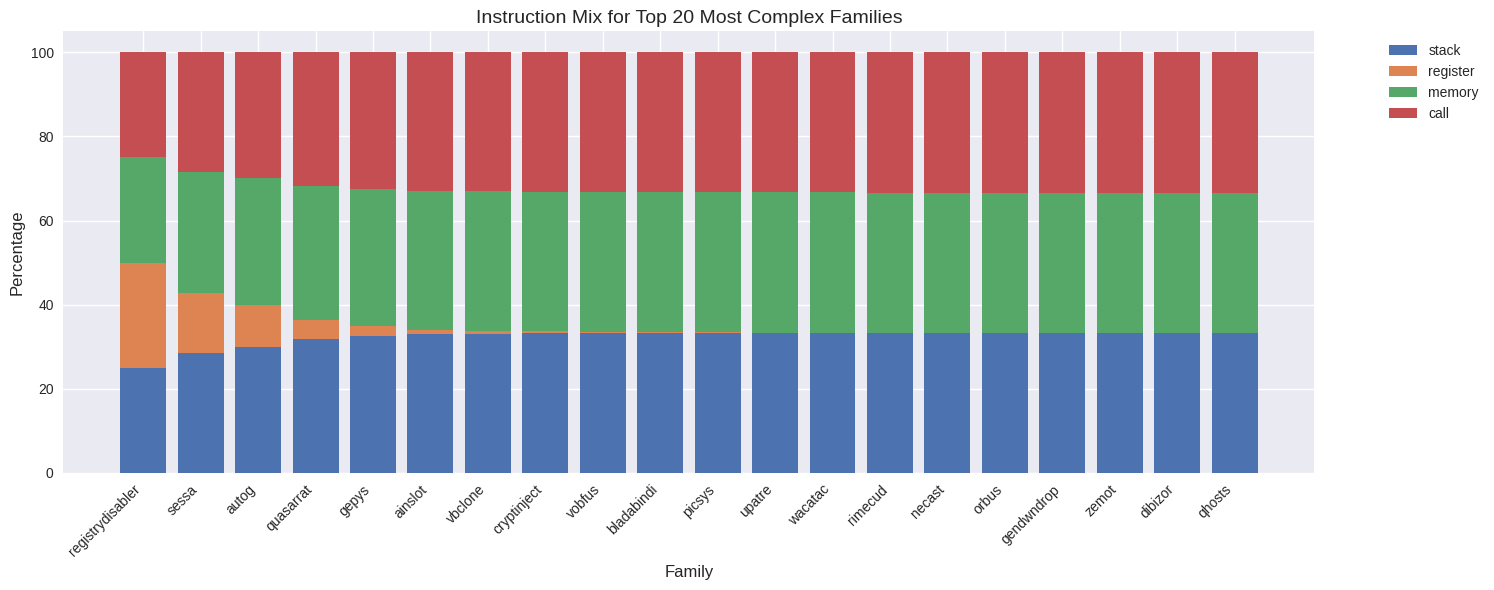

In [11]:

# Initialize visualizer with data from aggregator
visualizer = MalwareMetricsVisualizer2()
visualizer.load_data_from_aggregator(aggregator)

# Create visualizations
visualizer.plot_call_patterns()
visualizer.plot_complexity_metrics()
visualizer.plot_memory_behavior()
visualizer.plot_control_flow_patterns()
# plot_instruction_patterns
visualizer.plot_instruction_patterns()


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class BehavioralGroupAnalyzer:
    """Analyze behavioral groups for insights on malware families."""

    def __init__(self, groups_file: Path, similarity_matrix_file: Path):
        self.groups_file = groups_file
        self.similarity_matrix_file = similarity_matrix_file
        self.groups = self._load_groups()
        self.similarity_matrix = self._load_similarity_matrix()

    def _load_groups(self) -> dict:
        logger.info(f"Loading behavioral groups from {self.groups_file}")
        with open(self.groups_file, 'r') as f:
            groups = json.load(f)
        logger.info(f"Loaded {len(groups)} behavioral groups.")
        return groups

    def _load_similarity_matrix(self) -> np.ndarray:
        logger.info(f"Loading similarity matrix from {self.similarity_matrix_file}")
        return np.load(self.similarity_matrix_file)

    def summarize_groups(self):
        group_sizes = {k: len(v) for k, v in self.groups.items()}
        total_samples = sum(group_sizes.values())
        logger.info(f"Total samples: {total_samples}")
        logger.info(f"Number of groups: {len(group_sizes)}")
        logger.info(f"Average group size: {np.mean(list(group_sizes.values())):.2f}")

        plt.figure(figsize=(10, 6))
        sns.histplot(list(group_sizes.values()), bins=20, kde=False)
        plt.title("Behavioral Group Size Distribution")
        plt.xlabel("Group Size")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig("group_size_distribution.png")
        plt.close()

    def analyze_similarity_distribution(self):
        intra_group_sims = []
        inter_group_sims = []

        for group_id, families in self.groups.items():
            indices = [i for i, f in enumerate(families) if f in families]
            for i in indices:
                for j in indices:
                    if i != j:
                        intra_group_sims.append(self.similarity_matrix[i, j])
            for other_group_id, other_families in self.groups.items():
                if other_group_id != group_id:
                    other_indices = [i for i, f in enumerate(families) if f in other_families]
                    for i in indices:
                        for j in other_indices:
                            inter_group_sims.append(self.similarity_matrix[i, j])

        plt.figure(figsize=(10, 6))
        sns.histplot(intra_group_sims, bins=50, kde=True, color='blue', label='Intra-group')
        sns.histplot(inter_group_sims, bins=50, kde=True, color='red', label='Inter-group')
        plt.legend()
        plt.title("Similarity Distributions: Intra- vs. Inter-group")
        plt.xlabel("Similarity Score")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig("similarity_distributions.png")
        plt.close()

    def analyze_family_composition(self):
        family_counter = Counter()
        for group_id, families in self.groups.items():
            family_counter.update(families)

        top_families = family_counter.most_common(10)
        logger.info("Top 10 families by occurrence:")
        for family, count in top_families:
            logger.info(f"{family}: {count}")

        families, counts = zip(*top_families)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts, y=families, orient='h')
        plt.title("Top 10 Families by Occurrence")
        plt.xlabel("Count")
        plt.ylabel("Family")
        plt.tight_layout()
        plt.savefig("top_families.png")
        plt.close()

if __name__ == "__main__":
    analyzer = BehavioralGroupAnalyzer(
        groups_file=Path('/data/saranyav/gcn_new/behavioral_analysis/behavioral_groups.json'),
        similarity_matrix_file=Path('/data/saranyav/gcn_new/behavioral_analysis/similarity_matrix.npy')
    )

    analyzer.summarize_groups()
    analyzer.analyze_similarity_distribution()
    analyzer.analyze_family_composition()

    logger.info("Behavioral group analysis complete.")